
# Predictive Maintenance – Remaining Useful Life (RUL) Prediction  
## Geothermal Power Plant Case Study

This notebook presents an **end-to-end data analysis and machine learning workflow**
to predict the **Remaining Useful Life (RUL)** of geothermal power plant equipment
using historical sensor data.

**Objective:**  
Support predictive maintenance strategies by estimating time-to-failure,
reducing unplanned downtime, and optimizing maintenance scheduling.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

df = pd.read_table("/content/drive/MyDrive/Tugas Akhir/AE_Fix_Full/AE_FullDetection_Adaptive.tsv")

df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")

df = df.sort_values("Datetime").reset_index(drop=True)


/tmp/ipython-input-3696493963.py:4: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("/content/drive/MyDrive/Tugas Akhir/AE_Fix_Full/AE_FullDetection_Adaptive.tsv")


In [3]:
df.columns

Index(['Datetime', 'TURBINE SPEED(rpm)', 'ECCENTRICITY umP-P',
       'THRUST POSITION mm', 'NO.1 BEARING VIBRATION(X) umP-P',
       'NO.1 BEARING VIBRATION(Y) umP-P', 'NO.2 BEARING VIBRATION(X) umP-P',
       'NO.2 BEARING VIBRATION(Y) umP-P', 'NO.3 BEARING VIBRATION(X) umP-P',
       'NO.3 BEARING VIBRATION(Y) umP-P', 'NO.4 BEARING VIBRATION(X) umP-P',
       'NO.4 BEARING VIBRATION(Y) umP-P', 'MAIN OIL TANK OIL TEMP degC',
       'MAIN OIL COOLER OUTLET OIL TEMP degC', 'NO.3 BEARING METAL TEMP degC',
       'NO.4 BEARING METAL TEMP degC', 'THRUST BEARING METAL TEMP (F) degC',
       'RG (LS) BEARING METAL TEMP (R) degC',
       'RG (HS) BEARING METAL TEMP (F) degC',
       'NO.1 BEARING OIL DRAIN TEMP degC', 'NO.2 BEARING OIL DRAIN TEMP degC',
       'LUBE OIL PRESS barg', 'CONTROL OIL PRESS barg',
       'MS PRESS BEFORE STRAINER barg', 'MS TEMP degC', 'MAIN STEAM FLOW t/h',
       'STEAM TO EJECTOR FLOW t/h', 'TURBINE 1ST STAGE BOWL PRESS barg',
       'TURBINE EXH HOOD TEMP degC

In [4]:
sensor_cols = [
    'TURBINE SPEED(rpm)', 'ECCENTRICITY umP-P', 'THRUST POSITION mm',
    'NO.1 BEARING VIBRATION(X) umP-P', 'NO.1 BEARING VIBRATION(Y) umP-P',
    'NO.2 BEARING VIBRATION(X) umP-P', 'NO.2 BEARING VIBRATION(Y) umP-P',
    'NO.3 BEARING VIBRATION(X) umP-P', 'NO.3 BEARING VIBRATION(Y) umP-P',
    'NO.4 BEARING VIBRATION(X) umP-P', 'NO.4 BEARING VIBRATION(Y) umP-P',
    'MAIN OIL TANK OIL TEMP degC', 'MAIN OIL COOLER OUTLET OIL TEMP degC',
    'NO.3 BEARING METAL TEMP degC', 'NO.4 BEARING METAL TEMP degC',
    'THRUST BEARING METAL TEMP (F) degC', 'RG (LS) BEARING METAL TEMP (R) degC',
    'RG (HS) BEARING METAL TEMP (F) degC',
    'NO.1 BEARING OIL DRAIN TEMP degC', 'NO.2 BEARING OIL DRAIN TEMP degC',
    'LUBE OIL PRESS barg', 'CONTROL OIL PRESS barg',
    'MS PRESS BEFORE STRAINER barg', 'MS TEMP degC', 'MAIN STEAM FLOW t/h',
    'STEAM TO EJECTOR FLOW t/h', 'TURBINE 1ST STAGE BOWL PRESS barg',
    'TURBINE EXH HOOD TEMP degC', 'GLAND STEAM PRESS barg',
    'GEN. VOLTAGE kV', 'GEN. CURRENT A', 'GEN. FREQUENCY Hz',
    'GEN. REACTIVE POWER Mvar', 'GEN. POWER FACTOR PF',
    'GEN STATOR COIL TEMP U1 degC', 'GEN STATOR COIL TEMP U2 degC',
    'GEN STATOR COIL TEMP V1 degC', 'GEN STATOR COIL TEMP V2 degC',
    'GEN STATOR COIL TEMP W1 degC', 'GEN STATOR COIL TEMP W2 degC',
    'GEN AIR COOLER INL AIR TEMP degC', 'GEN AIR COOLER OUTL AIR TEMP degC',
    'MN CNDR VAP PRESS barg', 'MN CNDR COND TEMP degC', 'MN CNDR LVL %',
    'MN CNDR COND PRESS barg', 'MW SIGNAL MW'
]

keep_cols = ["Datetime", "Unplanned_Shutdown", "AE_Pred_Adapt", "Operational_Phase"] + sensor_cols
df = df[keep_cols].copy()


In [5]:
df = df.drop_duplicates("Datetime")

df = df.replace([np.inf, -np.inf], np.nan)

df[sensor_cols] = df[sensor_cols].interpolate(limit_direction="both")


In [6]:
df = df.sort_values("Datetime").reset_index(drop=True)

boundaries = (
    (df["Unplanned_Shutdown"].shift(fill_value=0) == 1) &
    (df["Unplanned_Shutdown"] == 0)
)

df["episode_id"] = boundaries.cumsum() + 1


In [7]:
df["episode_id"].value_counts()


,count
episode_id,
1,217440
3,28800
2,18720


In [8]:
def clean_shutdown(df):
    out = []
    for ep, g in df.groupby("episode_id"):
        shut_idx = g.index[g["Unplanned_Shutdown"] == 1].tolist()

        if len(shut_idx) > 1:
            keep = shut_idx[0]
            drop = shut_idx[1:]
            g = g.drop(drop)
        out.append(g)
    return pd.concat(out).sort_values("Datetime")

df = clean_shutdown(df)
df = df.reset_index(drop=True)


In [9]:
df["episode_id"].value_counts()


,count
episode_id,
1,152641
3,18721
2,7201


In [10]:
df_on = df[
    (df["Operational_Phase"] == "Rated Speed (On-Load)") |
    (df["Unplanned_Shutdown"] == 1)
].copy()

print("Rows before ON Load filter:", len(df))
print("Rows after ON-LOAD filter:", len(df_on))
print("Jumlah baris USD=1 yang dipertahankan:", df_on[df_on["Unplanned_Shutdown"]==1].shape[0])


Rows before ON Load filter: 178563
Rows after ON-LOAD filter: 175913
Jumlah baris USD=1 yang dipertahankan: 3


In [11]:
df_on["episode_id"].value_counts()


,count
episode_id,
1,150787
3,18221
2,6905


In [12]:
print(df_on.groupby("episode_id")["Unplanned_Shutdown"].sum())

episode_id
1    1
2    1
3    1
Name: Unplanned_Shutdown, dtype: int64


In [13]:
import pandas as pd
import numpy as np

df = df_on
TIME_COL = "Datetime" if "Datetime" in df.columns else "Date_Time"
EP_COL   = "episode_id"

df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.sort_values([EP_COL, TIME_COL], kind="mergesort").reset_index(drop=True)

HI_SENSORS = {
    "vib3x":  "NO.3 BEARING VIBRATION(X) umP-P",
    "vib4y":  "NO.4 BEARING VIBRATION(Y) umP-P",
    "thrust": "THRUST POSITION mm",
    "temp3":  "NO.3 BEARING METAL TEMP degC",
    "oilout": "MAIN OIL COOLER OUTLET OIL TEMP degC",
}

def robust_scale_per_episode(s: pd.Series) -> pd.Series:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or pd.isna(iqr):
        return pd.Series(0.0, index=s.index)
    scaled = (s - q1) / iqr
    return scaled.clip(0, 1)

for key, col in HI_SENSORS.items():
    df[f"HI_{key}_norm_v2"] = (
        df.groupby(EP_COL, group_keys=False)[col]
          .transform(robust_scale_per_episode)
    )

weights = {
    "vib3x": 0.25,
    "vib4y": 0.25,
    "thrust": 0.20,
    "temp3": 0.15,
    "oilout": 0.15,
}
total = sum(weights.values())
weights = {k: v/total for k,v in weights.items()}

df["HI_degraded_v2_raw"] = 0.0
for key in HI_SENSORS.keys():
    df["HI_degraded_v2_raw"] += weights[key] * df[f"HI_{key}_norm_v2"]

df["HI_degraded_v2_raw"] = df["HI_degraded_v2_raw"].clip(0, 1)

ALPHA = 0.03

def smooth_episode(s):
    return s.ewm(alpha=ALPHA, adjust=False).mean()

df["HI_degraded_v2_smooth"] = (
    df.groupby(EP_COL, group_keys=False)["HI_degraded_v2_raw"]
      .transform(smooth_episode)
)

df["HI_degraded_v2_smooth"] = df["HI_degraded_v2_smooth"].clip(0, 1)

df["HI_health_v2"] = 1 - df["HI_degraded_v2_smooth"]
df["HI_health_v2"] = df["HI_health_v2"].clip(0, 1)


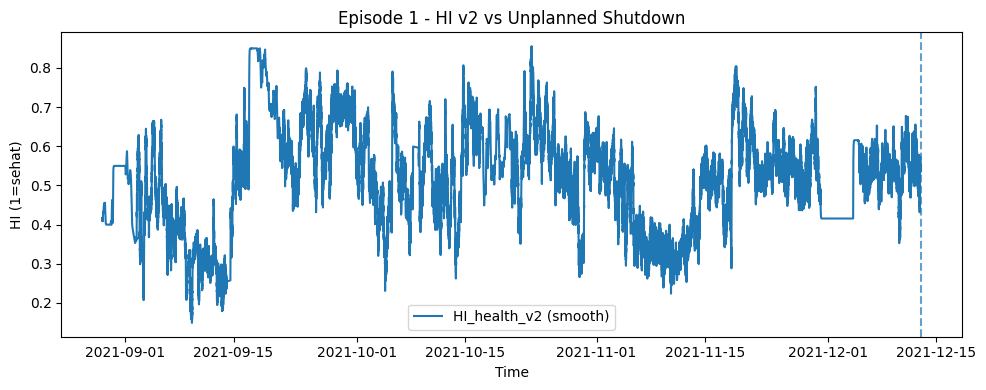

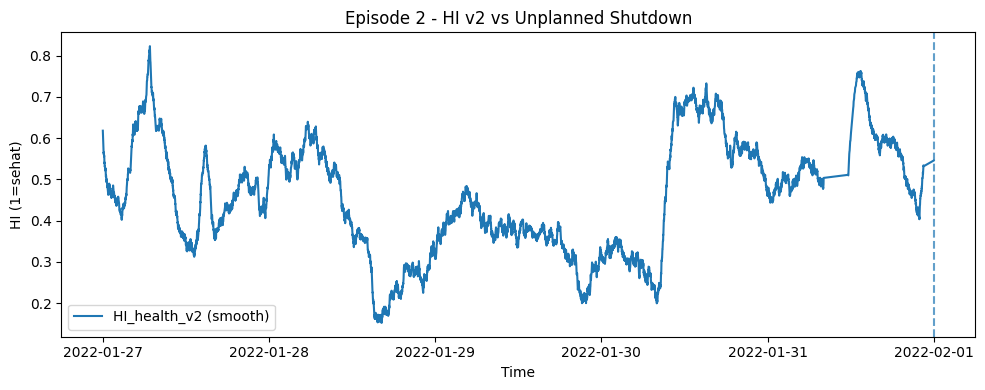

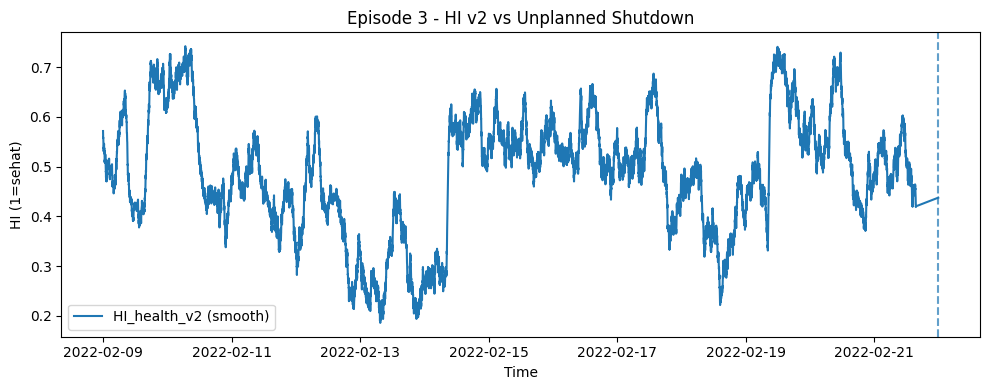

In [14]:
import matplotlib.pyplot as plt

for ep, grp in df.groupby(EP_COL):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v2"], label="HI_health_v2 (smooth)")

    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times:
        plt.axvline(t, linestyle="--", alpha=0.7)

    plt.title(f"Episode {ep} - HI v2 vs Unplanned Shutdown")
    plt.ylabel("HI (1=sehat)")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:

df["HI_degraded_v3"] = 0.0

for ep, grp in df.groupby("episode_id"):
    vals = grp["HI_degraded_v2_smooth"].values

    mono = vals.copy()
    for i in range(len(vals)-2, -1, -1):
        mono[i] = max(mono[i], mono[i+1])

    df.loc[grp.index, "HI_degraded_v3"] = mono

df["HI_health_v3"] = 1 - df["HI_degraded_v3"]
df["HI_health_v3"] = df["HI_health_v3"].clip(0, 1)


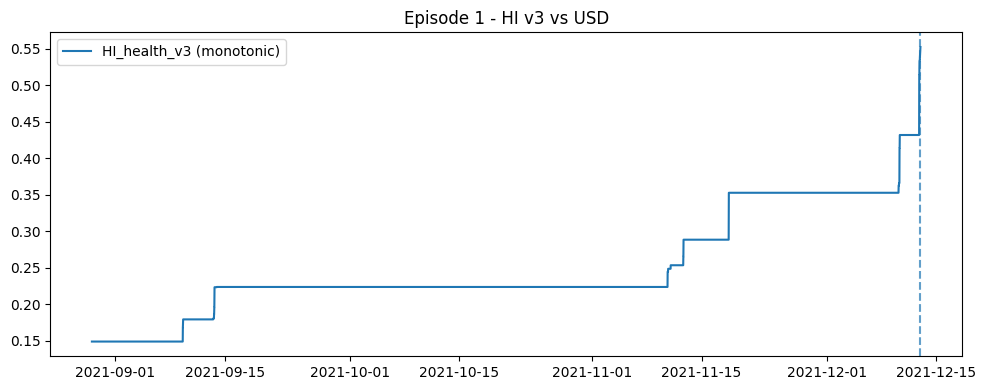

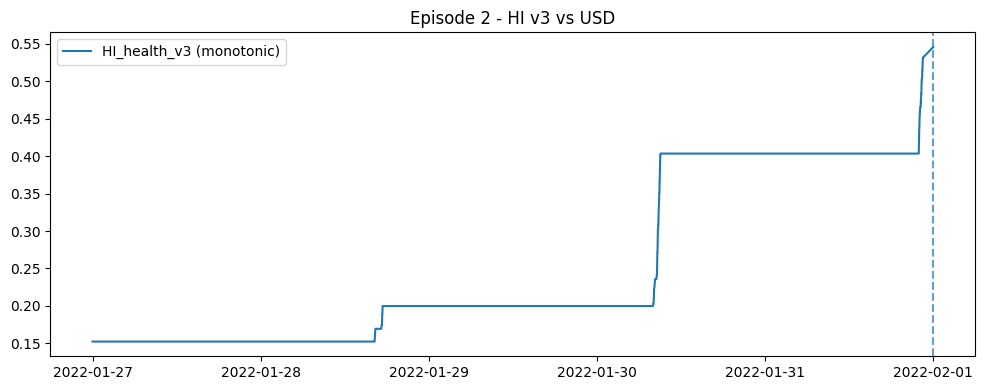

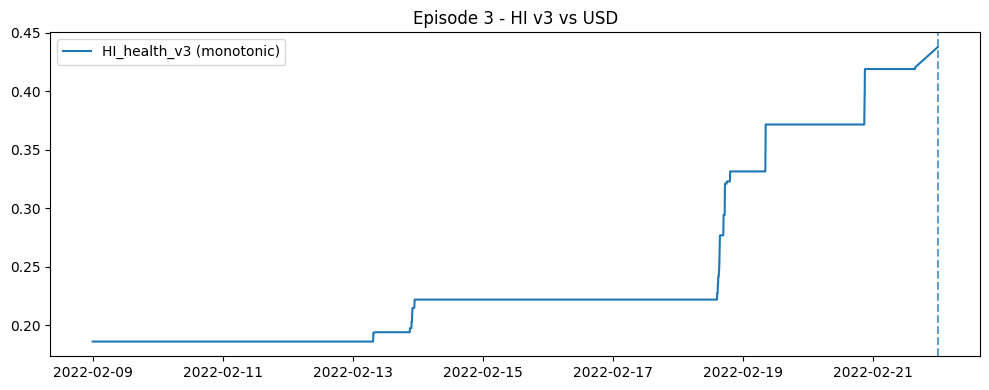

In [16]:
for ep, grp in df.groupby("episode_id"):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v3"], label="HI_health_v3 (monotonic)")
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times: plt.axvline(t, linestyle="--", alpha=0.7)
    plt.title(f"Episode {ep} - HI v3 vs USD")
    plt.legend(); plt.tight_layout(); plt.show()


In [17]:
def robust_scale_per_episode(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return pd.Series(0.0, index=s.index)
    return ((s - q1) / iqr).clip(0, 1)

for key, col in HI_SENSORS.items():
    df[f"HI_{key}_norm_v4"] = (
        df.groupby("episode_id", group_keys=False)[col]
          .transform(robust_scale_per_episode)
    )

df["HI_degraded_v4"] = 0
for k in HI_SENSORS.keys():
    df["HI_degraded_v4"] += weights[k] * df[f"HI_{k}_norm_v4"]

df["HI_degraded_v4"] = df["HI_degraded_v4"].clip(0,1)

df["HI_degraded_v4_s1"] = (
    df.groupby("episode_id", group_keys=False)["HI_degraded_v4"]
      .transform(lambda s: s.ewm(alpha=0.04, adjust=False).mean())
)

df["HI_degraded_v4_s2"] = (
    df.groupby("episode_id", group_keys=False)["HI_degraded_v4_s1"]
      .transform(lambda s: s.rolling(60, min_periods=1).median())
)

df["HI_health_v4"] = 1 - df["HI_degraded_v4_s2"]
df["HI_health_v4"] = df["HI_health_v4"].clip(0,1)


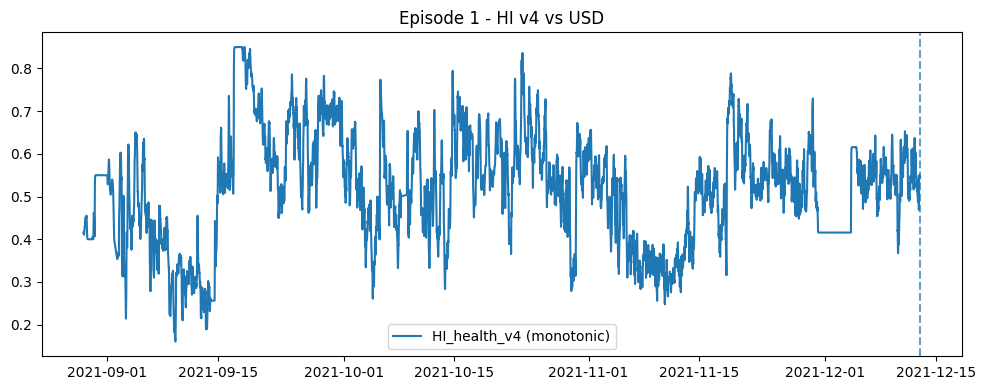

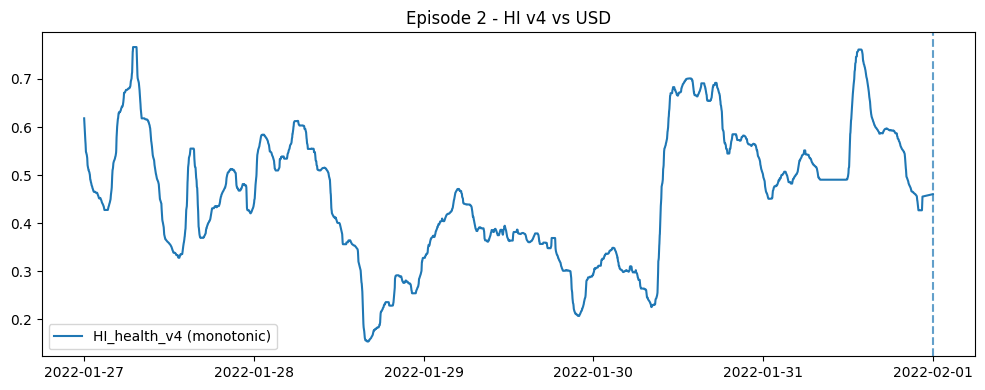

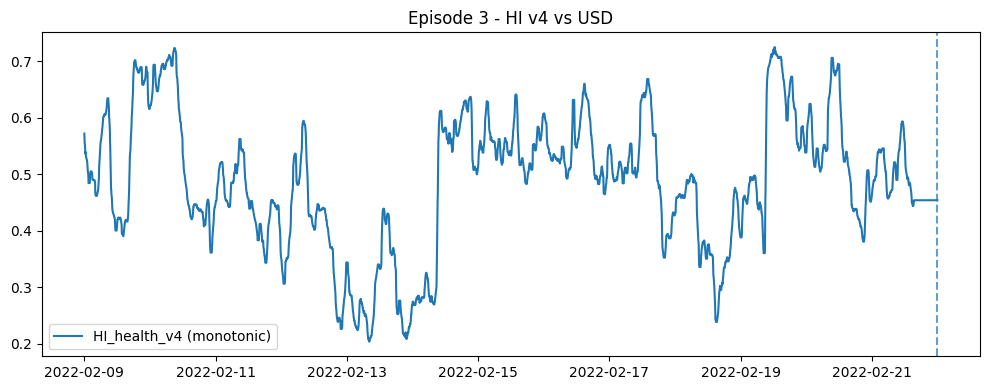

In [18]:
for ep, grp in df.groupby("episode_id"):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v4"], label="HI_health_v4 (monotonic)")
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times: plt.axvline(t, linestyle="--", alpha=0.7)
    plt.title(f"Episode {ep} - HI v4 vs USD")
    plt.legend(); plt.tight_layout(); plt.show()

In [19]:
import pandas as pd
import numpy as np

TIME_COL = "Datetime" if "Datetime" in df.columns else "Date_Time"
EP_COL   = "episode_id"

df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.sort_values([EP_COL, TIME_COL], kind="mergesort").reset_index(drop=True)

HI_SENSORS = {
    "vib3x":  "NO.3 BEARING VIBRATION(X) umP-P",
    "vib4y":  "NO.4 BEARING VIBRATION(Y) umP-P",
    "thrust": "THRUST POSITION mm",
    "temp3":  "NO.3 BEARING METAL TEMP degC",
    "oilout": "MAIN OIL COOLER OUTLET OIL TEMP degC",
}

weights = {
    "vib3x":  0.25,
    "vib4y":  0.25,
    "thrust": 0.20,
    "temp3":  0.15,
    "oilout": 0.15,
}
w_sum = sum(weights.values())
weights = {k: v / w_sum for k, v in weights.items()}   # normalisasi total=1

qs = {}
for key, col in HI_SENSORS.items():
    q_low  = df[col].quantile(0.10)   # 10% → buang noise bawah
    q_high = df[col].quantile(0.90)   # 90% → buang spike atas
    qs[key] = (q_low, q_high)
    print(f"{col}: q10={q_low:.3f}, q90={q_high:.3f}")

def global_scale_series(s: pd.Series, q_low: float, q_high: float) -> pd.Series:
    rng = q_high - q_low
    if rng == 0 or pd.isna(rng):
        return pd.Series(0.5, index=s.index)  # kalau flat, set tengah
    scaled = (s - q_low) / rng
    return scaled.clip(0, 1)

for key, col in HI_SENSORS.items():
    q_low, q_high = qs[key]
    df[f"HI_{key}_norm_v5"] = global_scale_series(df[col], q_low, q_high)


df["HI_degraded_v5_raw"] = 0.0
for key in HI_SENSORS.keys():
    df["HI_degraded_v5_raw"] += weights[key] * df[f"HI_{key}_norm_v5"]

df["HI_degraded_v5_raw"] = df["HI_degraded_v5_raw"].clip(0, 1)

ALPHA = 0.03      # EWMA lebih berat = lebih halus
ROLL_W = 60       # 60 menit, bisa kamu naikkan ke 120 kalau mau super halus

def smooth_episode(values: pd.Series) -> pd.Series:
    s1 = values.ewm(alpha=ALPHA, adjust=False).mean()
    s2 = s1.rolling(ROLL_W, min_periods=1, center=False).mean()
    return s2

df["HI_degraded_v5_smooth"] = (
    df.groupby(EP_COL, group_keys=False)["HI_degraded_v5_raw"]
      .transform(smooth_episode)
)

df["HI_degraded_v5_smooth"] = df["HI_degraded_v5_smooth"].clip(0, 1)

df["HI_health_v5"] = 1.0 - df["HI_degraded_v5_smooth"]
df["HI_health_v5"] = df["HI_health_v5"].clip(0, 1)


NO.3 BEARING VIBRATION(X) umP-P: q10=18.000, q90=21.000
NO.4 BEARING VIBRATION(Y) umP-P: q10=13.000, q90=14.000
THRUST POSITION mm: q10=0.279, q90=0.293
NO.3 BEARING METAL TEMP degC: q10=49.900, q90=52.300
MAIN OIL COOLER OUTLET OIL TEMP degC: q10=40.800, q90=43.200


In [20]:
df["HI_health_v6"] = df["HI_health_v5"].copy()

shutdown_idx = df.index[df["Unplanned_Shutdown"] == 1]

for idx in shutdown_idx:
    ep = df.loc[idx, EP_COL]
    grp = df[df[EP_COL] == ep]

    t_shutdown = df.loc[idx, TIME_COL]
    window_grp = grp[grp[TIME_COL] < t_shutdown].tail(60)

    if len(window_grp) > 0:
        df.loc[idx, "HI_health_v6"] = window_grp["HI_health_v5"].min()
    else:
        df.loc[idx, "HI_health_v6"] = 0.0
df.loc[df["Unplanned_Shutdown"] == 1, "HI_health_v6"] = 0.0


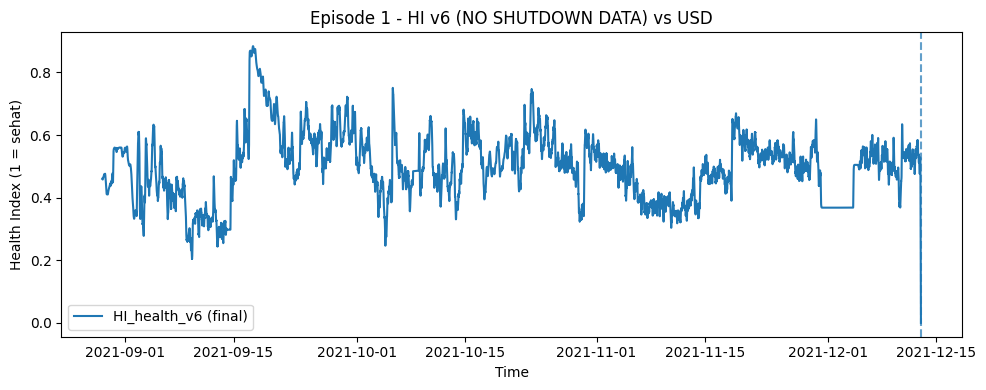

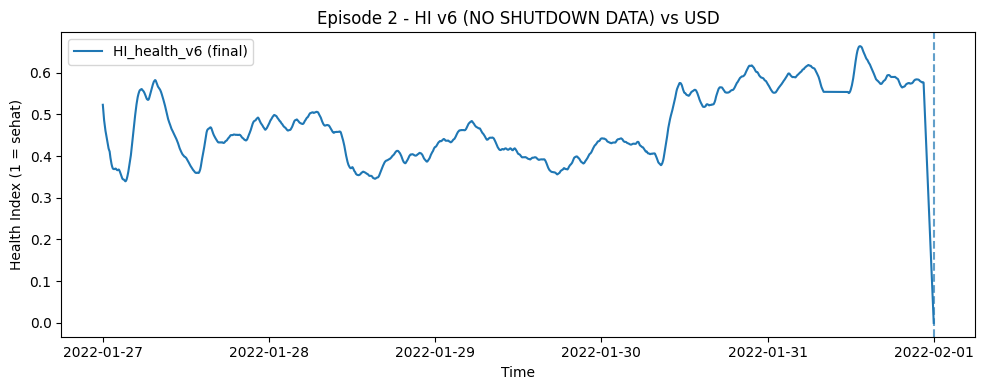

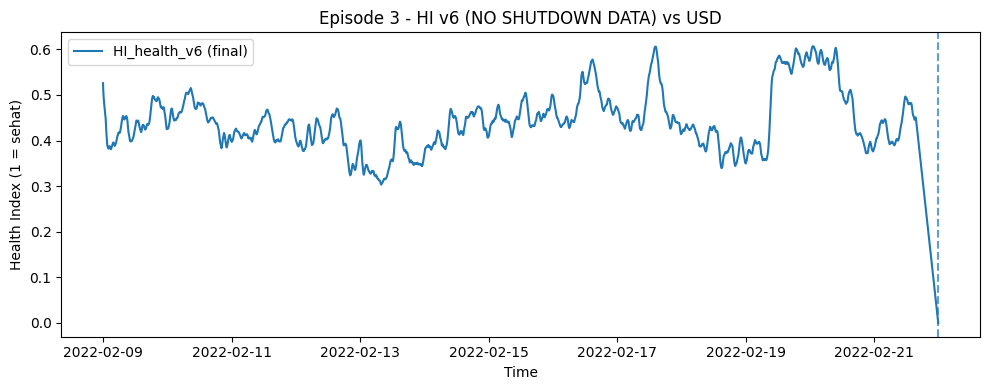

In [21]:
for ep, grp in df.groupby(EP_COL):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v6"], label="HI_health_v6 (final)", linewidth=1.5)
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times:
        plt.axvline(t, linestyle="--", alpha=0.7)

    plt.title(f"Episode {ep} - HI v6 (NO SHUTDOWN DATA) vs USD")
    plt.xlabel("Time")
    plt.ylabel("Health Index (1 = sehat)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
window_minutes = 120

df["HI_health_v7"] = df["HI_health_v6"].copy()

for ep, grp in df.groupby(EP_COL):
    shutdown_time = grp.loc[grp["Unplanned_Shutdown"] == 1, TIME_COL]
    if len(shutdown_time) == 0:
        continue
    shutdown_time = shutdown_time.iloc[0]

    mask = (grp[TIME_COL] >= shutdown_time - pd.Timedelta(minutes=window_minutes)) & \
           (grp[TIME_COL] < shutdown_time)
    idxs = grp[mask].index

    if len(idxs) == 0:
        continue

    start_val = df.loc[idxs[0], "HI_health_v6"]
    end_val   = grp["HI_health_v6"].quantile(0.05)  # nilai health terburuk

    ramp = np.linspace(start_val, end_val, len(idxs))
    df.loc[idxs, "HI_health_v7"] = ramp

df.loc[df["Unplanned_Shutdown"] == 1, "HI_health_v7"] = 0.0


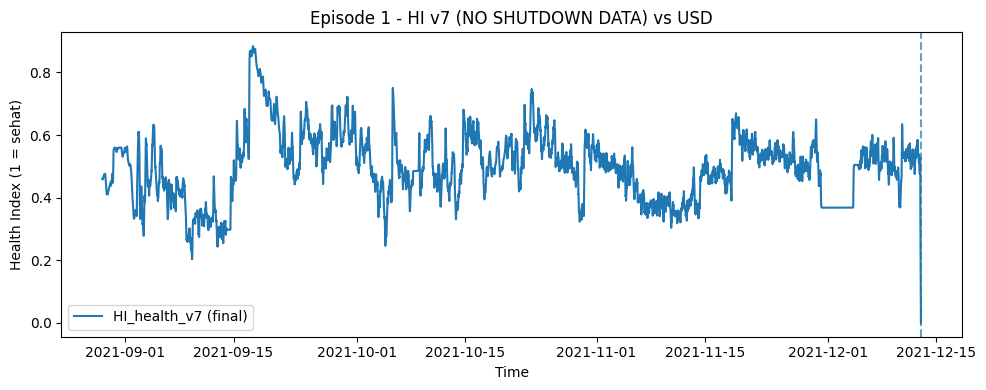

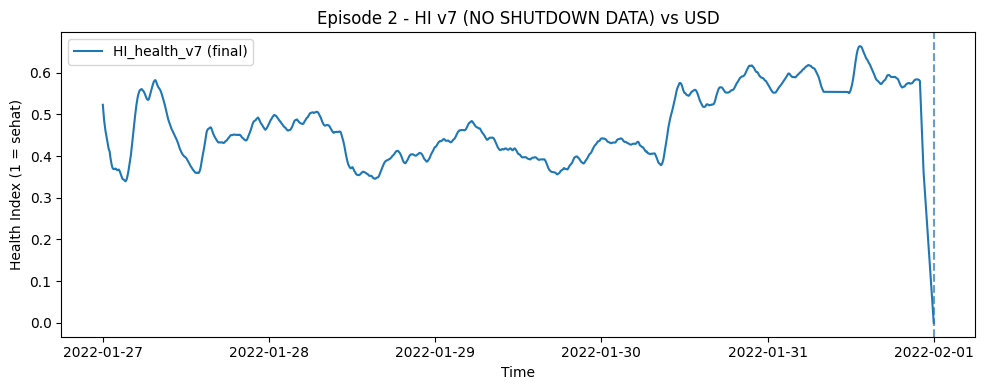

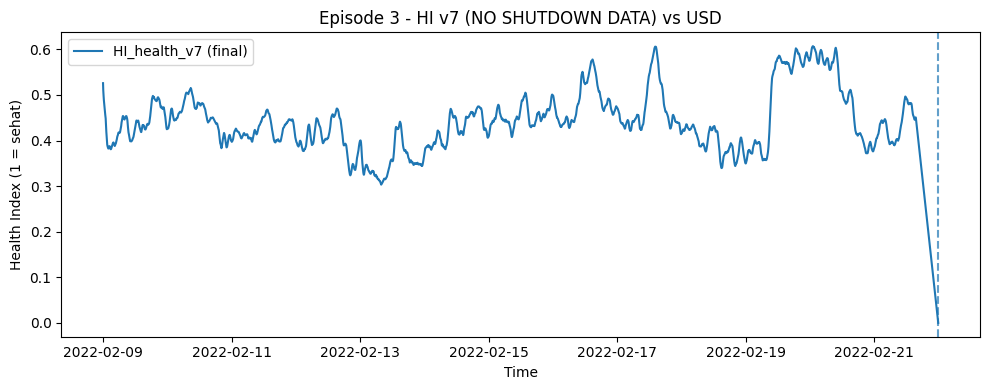

In [23]:
import matplotlib.pyplot as plt

for ep, grp in df.groupby(EP_COL):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v7"], label="HI_health_v7 (final)", linewidth=1.5)
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times:
        plt.axvline(t, linestyle="--", alpha=0.7)

    plt.title(f"Episode {ep} - HI v7 (NO SHUTDOWN DATA) vs USD")
    plt.xlabel("Time")
    plt.ylabel("Health Index (1 = sehat)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
import numpy as np
import pandas as pd

BASE_COL = "HI_health_v6"   # gunakan v6 sebagai basis
EP_COL   = EP_COL
TIME_COL = TIME_COL

df["HI_health_v8"] = df[BASE_COL].astype(float)

for ep, grp in df.groupby(EP_COL):
    grp = grp.sort_values(TIME_COL)
    idx = grp.index

    hi = grp[BASE_COL].values.astype(float)

    hi_norm = (hi - hi.min()) / (hi.max() - hi.min() + 1e-6)

    hi_mono = np.minimum.accumulate(hi_norm)

    hi_sm = pd.Series(hi_mono, index=idx).rolling(
        120, min_periods=1
    ).mean()

    df.loc[idx, "HI_health_v8"] = hi_sm.values

df.loc[df["Unplanned_Shutdown"] == 1, "HI_health_v8"] = 0.0

df["HI_health_v8"] = df["HI_health_v8"].clip(0, 1)

df["HI_slope_v8"] = (
    df.sort_values(TIME_COL)
      .groupby(EP_COL)["HI_health_v8"]
      .diff()
      .fillna(0)
)


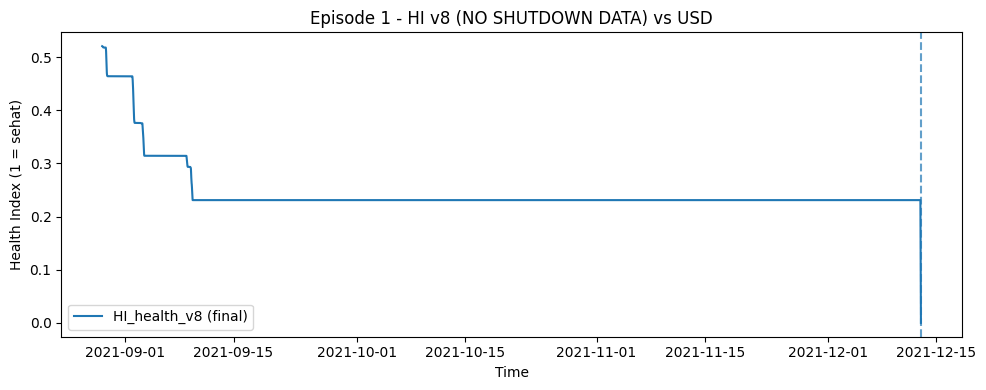

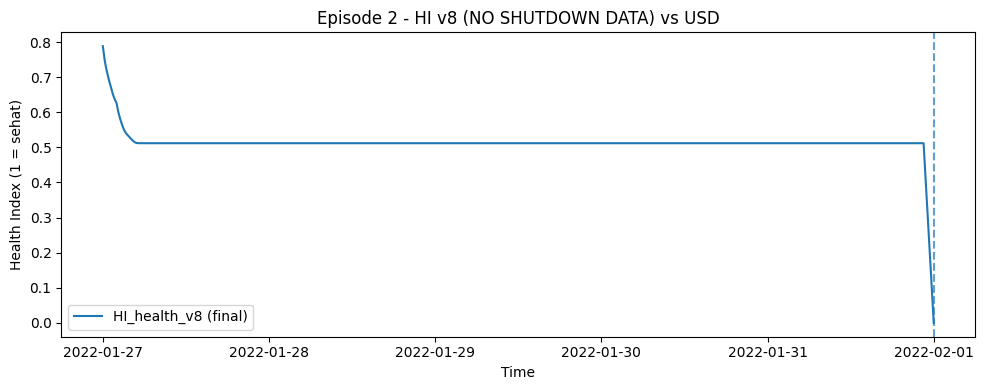

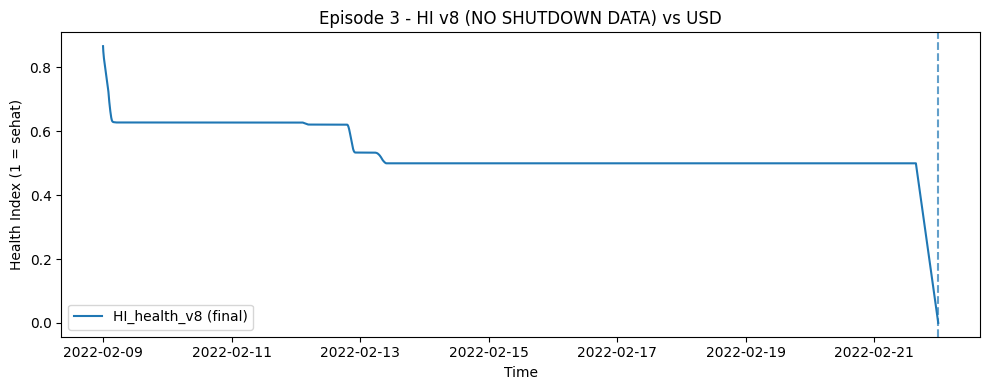

In [25]:
import matplotlib.pyplot as plt

for ep, grp in df.groupby(EP_COL):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v8"], label="HI_health_v8 (final)", linewidth=1.5)
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times:
        plt.axvline(t, linestyle="--", alpha=0.7)

    plt.title(f"Episode {ep} - HI v8 (NO SHUTDOWN DATA) vs USD")
    plt.xlabel("Time")
    plt.ylabel("Health Index (1 = sehat)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
import numpy as np
import pandas as pd

EP_COL   = EP_COL
TIME_COL = TIME_COL

df["HI_health_v9"] = 0.0

for ep, grp in df.groupby(EP_COL):
    grp = grp.sort_values(TIME_COL)
    idx = grp.index

    hi6 = grp["HI_health_v6"].astype(float)

    hi_short = hi6.rolling(60, min_periods=1).mean()

    hi_long = hi6.rolling(720, min_periods=1).mean()

    n = len(grp)
    decay = np.linspace(1.0, 0.85, n)  # turun pelan 15% per episode

    hi_v9 = (
        0.6 * hi_long +
        0.3 * hi_short +
        0.1 * decay
    )

    hi_v9 = (hi_v9 - hi_v9.min()) / (hi_v9.max() - hi_v9.min() + 1e-6)

    df.loc[idx, "HI_health_v9"] = hi_v9

df.loc[df["Unplanned_Shutdown"] == 1, "HI_health_v9"] = 0.0


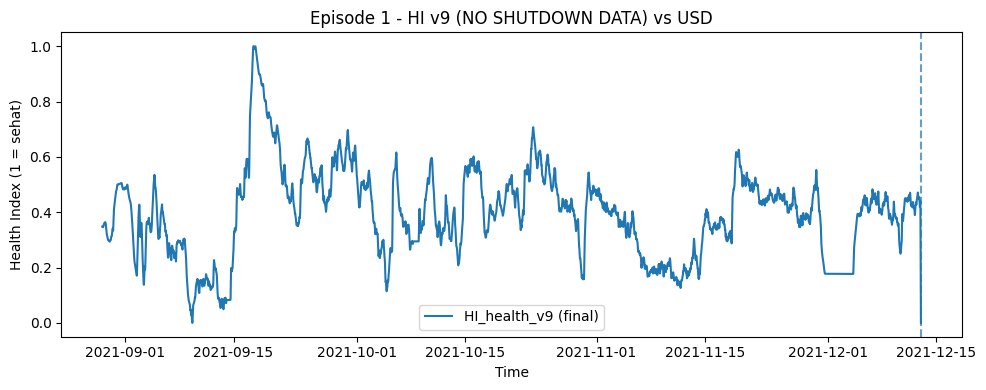

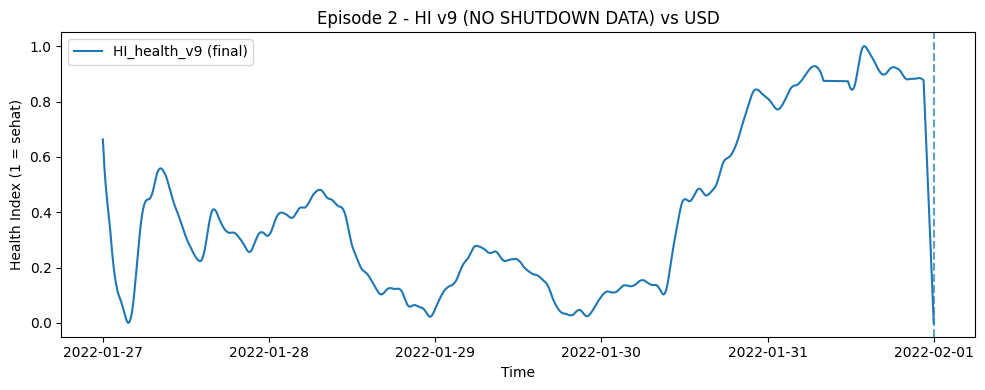

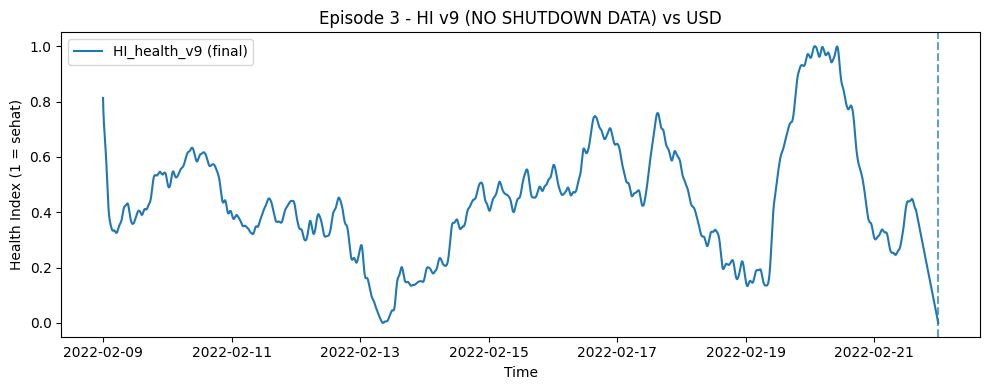

In [27]:
import matplotlib.pyplot as plt

for ep, grp in df.groupby(EP_COL):
    plt.figure(figsize=(10,4))
    plt.plot(grp[TIME_COL], grp["HI_health_v9"], label="HI_health_v9 (final)", linewidth=1.5)
    usd_times = grp.loc[grp["Unplanned_Shutdown"]==1, TIME_COL]
    for t in usd_times:
        plt.axvline(t, linestyle="--", alpha=0.7)

    plt.title(f"Episode {ep} - HI v9 (NO SHUTDOWN DATA) vs USD")
    plt.xlabel("Time")
    plt.ylabel("Health Index (1 = sehat)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
df["row_index"] = df.groupby("episode_id").cumcount()

max_idx = df.groupby("episode_id")["row_index"].transform("max")

df["RUL_rows"] = max_idx - df["row_index"]

df["RUL_minutes"] = df["RUL_rows"] * 1
df["RUL_hours"] = df["RUL_minutes"] / 60


In [29]:
df.groupby("episode_id")["RUL_minutes"].agg(['min','max'])


,min,max
episode_id,,
1,0,150786
2,0,6904
3,0,18220


In [30]:
import numpy as np
import pandas as pd

EP_COL   = EP_COL
TIME_COL = TIME_COL

df = df.sort_values([EP_COL, TIME_COL]).reset_index(drop=True)

ae_thr = df["AE_Pred_Adapt"].quantile(0.98)   # misal hanya top 2% dianggap tinggi
print("AE threshold:", ae_thr)

df["AE_high"] = (df["AE_Pred_Adapt"] >= ae_thr).astype(int)

def keep_persistent_ae(grp, min_len=10):
    """
    min_len = minimal panjang segmen AE_high=1 agar dianggap valid
              (misal 10 poin = 10 menit kalau data per menit)
    """
    grp = grp.sort_values(TIME_COL)

    is_high = grp["AE_high"] == 1

    seg_id = (is_high != is_high.shift(fill_value=False)).cumsum()
    grp["AE_seg_id"] = np.where(is_high, seg_id, 0)

    seg_len = grp.groupby("AE_seg_id")["AE_seg_id"].transform("size")

    grp["AE_persist_flag"] = np.where(
        (grp["AE_seg_id"] > 0) & (seg_len >= min_len),
        1,
        0
    )

    grp["AE_Pred_Adapt_persist"] = np.where(
        grp["AE_persist_flag"] == 1,
        grp["AE_Pred_Adapt"],
        0.0
    )

    return grp

df = (
    df
    .groupby(EP_COL, group_keys=False)
    .apply(keep_persistent_ae, min_len=10)   # ganti 10 sesuai minimal durasi (poin)
)

df = df.drop(columns=["AE_high", "AE_seg_id"])


AE threshold: 1.0


/tmp/ipython-input-2578174107.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_persistent_ae, min_len=10)   # ganti 10 sesuai minimal durasi (poin)


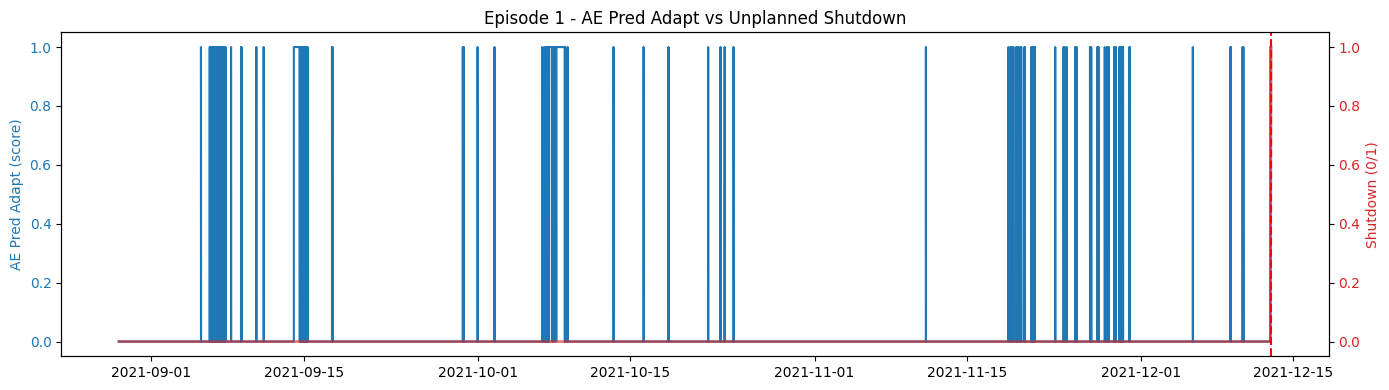

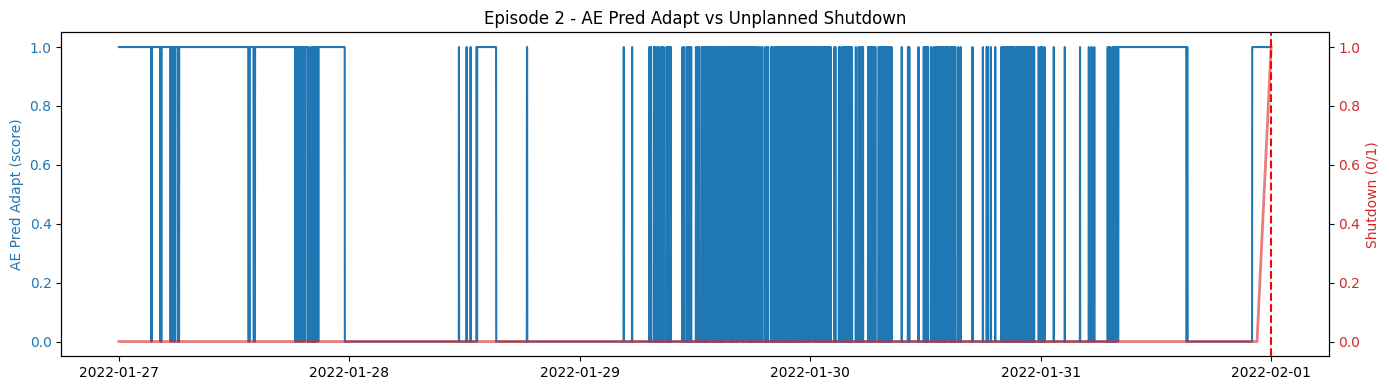

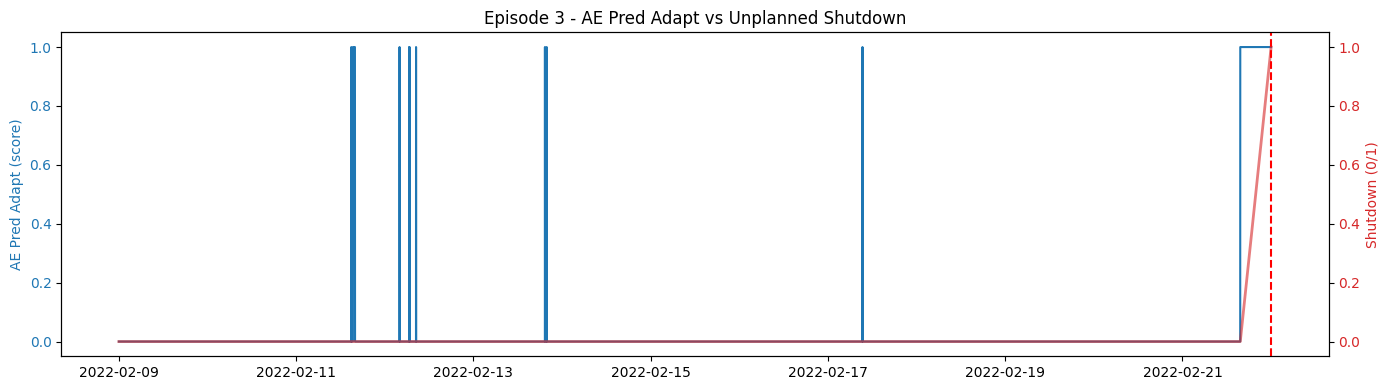

In [31]:
import matplotlib.pyplot as plt

EP_COL   = EP_COL
TIME_COL = TIME_COL

for ep, grp in df.groupby(EP_COL):
    grp = grp.sort_values(TIME_COL)

    fig, ax1 = plt.subplots(figsize=(14,4))

    ax1.plot(
        grp[TIME_COL],
        grp["AE_Pred_Adapt"],
        label="AE_Pred_Adapt",
        color="tab:blue"
    )
    ax1.set_ylabel("AE Pred Adapt (score)", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.plot(
        grp[TIME_COL],
        grp["Unplanned_Shutdown"]*1.0,
        label="Unplanned_Shutdown",
        color="tab:red",
        linewidth=2,
        alpha=0.6
    )
    ax2.set_ylabel("Shutdown (0/1)", color="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    usd_times = grp.loc[grp["Unplanned_Shutdown"] == 1, TIME_COL]
    if len(usd_times) > 0:
        plt.axvline(usd_times.iloc[0], color="red", linestyle="--")

    plt.title(f"Episode {ep} - AE Pred Adapt vs Unplanned Shutdown")
    plt.tight_layout()

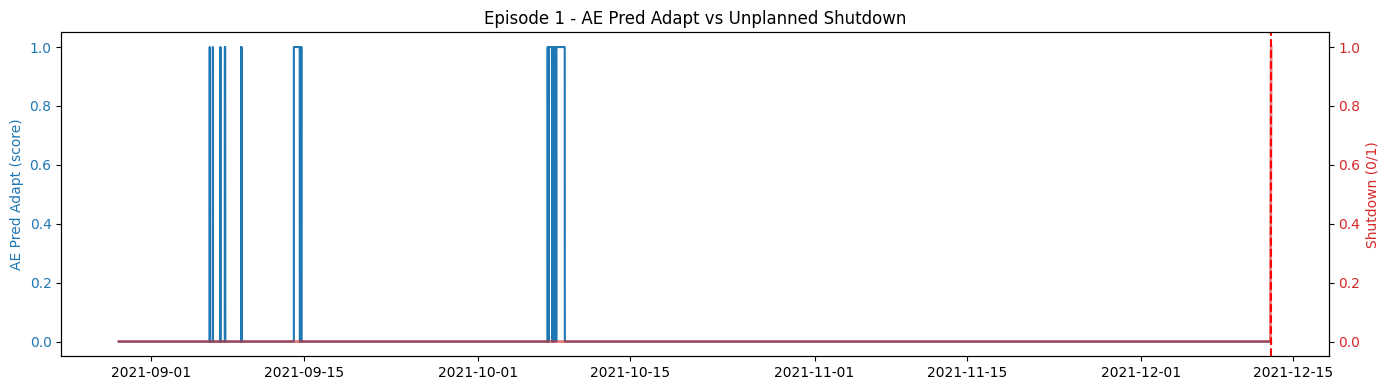

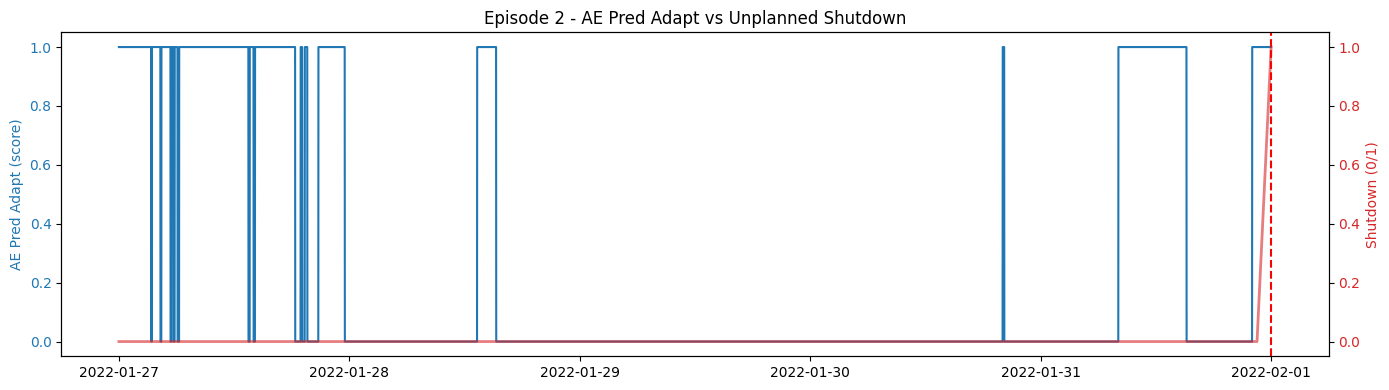

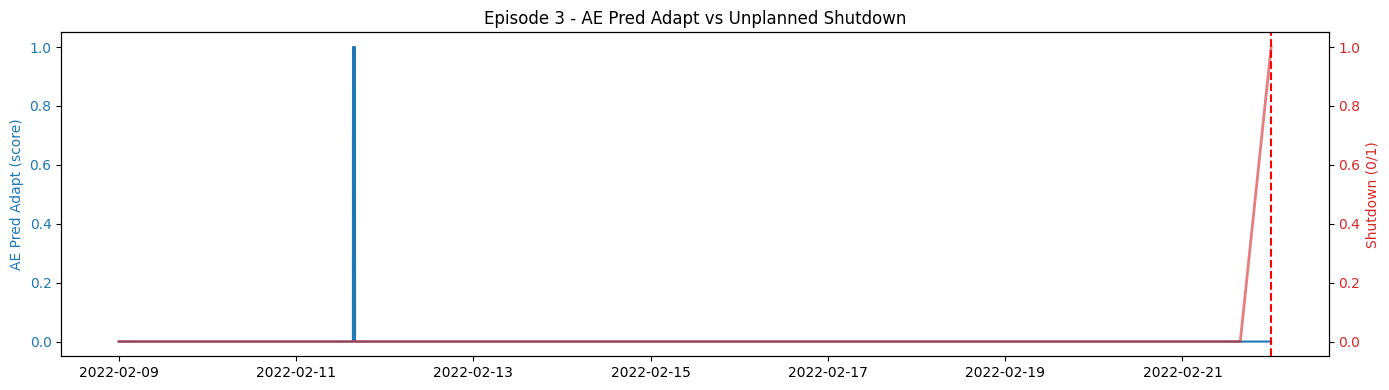

In [32]:
import matplotlib.pyplot as plt

EP_COL   = EP_COL
TIME_COL = TIME_COL

for ep, grp in df.groupby(EP_COL):
    grp = grp.sort_values(TIME_COL)

    fig, ax1 = plt.subplots(figsize=(14,4))

    ax1.plot(
        grp[TIME_COL],
        grp["AE_Pred_Adapt_persist"],
        label="AE_Pred_Adapt",
        color="tab:blue"
    )
    ax1.set_ylabel("AE Pred Adapt (score)", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.plot(
        grp[TIME_COL],
        grp["Unplanned_Shutdown"]*1.0,
        label="Unplanned_Shutdown",
        color="tab:red",
        linewidth=2,
        alpha=0.6
    )
    ax2.set_ylabel("Shutdown (0/1)", color="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    usd_times = grp.loc[grp["Unplanned_Shutdown"] == 1, TIME_COL]
    if len(usd_times) > 0:
        plt.axvline(usd_times.iloc[0], color="red", linestyle="--")

    plt.title(f"Episode {ep} - AE Pred Adapt vs Unplanned Shutdown")
    plt.tight_layout()
    plt.show()


In [33]:
df

,Datetime,Unplanned_Shutdown,AE_Pred_Adapt,Operational_Phase,TURBINE SPEED(rpm),ECCENTRICITY umP-P,THRUST POSITION mm,NO.1 BEARING VIBRATION(X) umP-P,NO.1 BEARING VIBRATION(Y) umP-P,NO.2 BEARING VIBRATION(X) umP-P,...,HI_health_v7,HI_health_v8,HI_slope_v8,HI_health_v9,row_index,RUL_rows,RUL_minutes,RUL_hours,AE_persist_flag,AE_Pred_Adapt_persist
0,2021-08-29 00:00:00,0,0,Rated Speed (On-Load),4881.0,0.0,0.287,29.0,14.0,30.0,...,0.460217,0.520618,0.000000,0.347750,0,150786,150786,2513.100000,0,0.0
1,2021-08-29 00:01:00,0,0,Rated Speed (On-Load),4877.0,0.0,0.287,29.0,14.0,30.0,...,0.460217,0.520618,0.000000,0.347750,1,150785,150785,2513.083333,0,0.0
2,2021-08-29 00:02:00,0,0,Rated Speed (On-Load),4879.0,0.0,0.287,29.0,14.0,30.0,...,0.460279,0.520618,0.000000,0.347783,2,150784,150784,2513.066667,0,0.0
3,2021-08-29 00:03:00,0,0,Rated Speed (On-Load),4884.0,0.0,0.287,29.0,14.0,30.0,...,0.460356,0.520618,0.000000,0.347830,3,150783,150783,2513.050000,0,0.0
4,2021-08-29 00:04:00,0,0,Rated Speed (On-Load),4890.0,0.0,0.287,29.0,14.0,30.0,...,0.460400,0.520618,0.000000,0.347872,4,150782,150782,2513.033333,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175908,2022-02-21 15:36:00,0,0,Rated Speed (On-Load),4884.0,0.0,0.282,21.0,11.0,31.0,...,0.450683,0.499579,0.000000,0.410680,18216,4,4,0.066667,0,0.0
175909,2022-02-21 15:37:00,0,0,Rated Speed (On-Load),4884.0,0.0,0.282,21.0,12.0,31.0,...,0.450296,0.499579,0.000000,0.410593,18217,3,3,0.050000,0,0.0
175910,2022-02-21 15:38:00,0,0,Rated Speed (On-Load),4887.0,0.0,0.282,20.0,11.0,31.0,...,0.449864,0.499579,0.000000,0.410500,18218,2,2,0.033333,0,0.0
175911,2022-02-21 15:39:00,0,1,Rated Speed (On-Load),4825.0,0.0,-0.004,21.0,9.0,28.0,...,0.449370,0.499579,0.000000,0.410399,18219,1,1,0.016667,0,0.0


In [33]:
df = df.sort_values(["episode_id", "Datetime"]).reset_index(drop=True)

df["RUL_minutes"] = 0  # init

for ep, grp in df.groupby("episode_id"):
    idx = grp.index
    length = len(grp)
    df.loc[idx, "RUL_minutes"] = np.arange(length-1, -1, -1)


In [34]:
MAX_RUL = 10080
df["RUL_minutes"] = df["RUL_minutes"].clip(upper=MAX_RUL)


In [35]:
df["RUL_minutes"].describe()


,RUL_minutes
count,175913.000000
mean,9242.183466
std,2249.541341
min,0.000000
25%,10080.000000
50%,10080.000000
75%,10080.000000
max,10080.000000


In [36]:
print(df["RUL_minutes"].describe())
print("Jumlah RUL < 0:", (df["RUL_minutes"] < 0).sum())

for ep, grp in df.groupby(EP_COL):
    diff = grp.sort_values(TIME_COL)["RUL_minutes"].diff().dropna()
    print(ep, (diff > 0).sum(), "naik (harusnya 0 atau kecil sekali)")


count    175913.000000
mean       9242.183466
std        2249.541341
min           0.000000
25%       10080.000000
50%       10080.000000
75%       10080.000000
max       10080.000000
Name: RUL_minutes, dtype: float64
Jumlah RUL < 0: 0
1 0 naik (harusnya 0 atau kecil sekali)
2 0 naik (harusnya 0 atau kecil sekali)
3 0 naik (harusnya 0 atau kecil sekali)


In [37]:
print(df["Operational_Phase"].value_counts())
print(df[df["Unplanned_Shutdown"] == 1][[EP_COL, TIME_COL]].head())


Operational_Phase
Rated Speed (On-Load)    175910
Turning Gear                  3
Name: count, dtype: int64
        episode_id   Datetime
150786           1 2021-12-13
157691           2 2022-02-01
175912           3 2022-02-22


In [38]:
EP_COL   = "episode_id"
TIME_COL = "Datetime"

df = df.sort_values([EP_COL, TIME_COL]).reset_index(drop=True)

ae_thr = df["AE_Pred_Adapt_persist"].quantile(0.98)
df["AE_high"] = (df["AE_Pred_Adapt_persist"] >= ae_thr).astype(int)

def make_ae_count(grp):
    grp = grp.sort_values(TIME_COL).copy()

    grp["AE_count"] = grp["AE_high"].cumsum()

    if grp["AE_count"].max() > 0:
        grp["AE_count_norm"] = grp["AE_count"] / grp["AE_count"].max()
    else:
        grp["AE_count_norm"] = 0.0

    return grp

df = df.groupby(EP_COL, group_keys=False).apply(make_ae_count)



/tmp/ipython-input-3963453069.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(EP_COL, group_keys=False).apply(make_ae_count)


In [39]:
print(df.groupby("episode_id")["AE_count"].max())
print(df.groupby("episode_id")["AE_count_norm"].max())


episode_id
1    150787
2      6905
3     18221
Name: AE_count, dtype: int64
episode_id
1    1.0
2    1.0
3    1.0
Name: AE_count_norm, dtype: float64


In [41]:
df.to_csv("/content/drive/MyDrive/Tugas Akhir/Dataset/sumpah ini dataset fix banget ga bohong gais.csv")

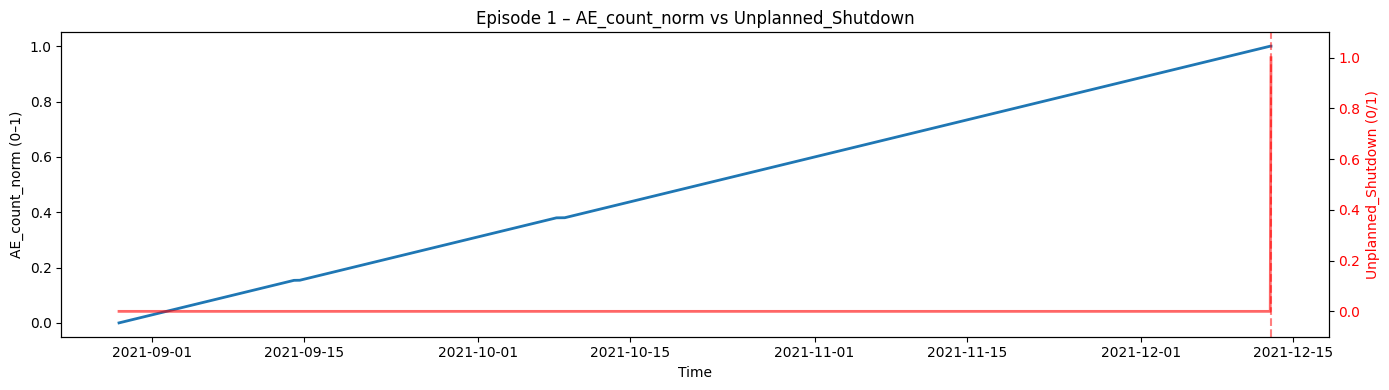

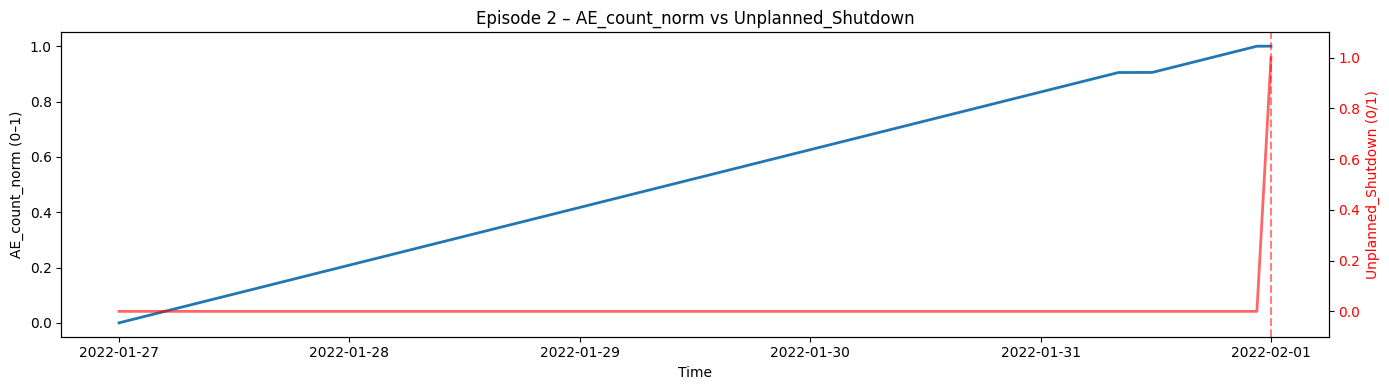

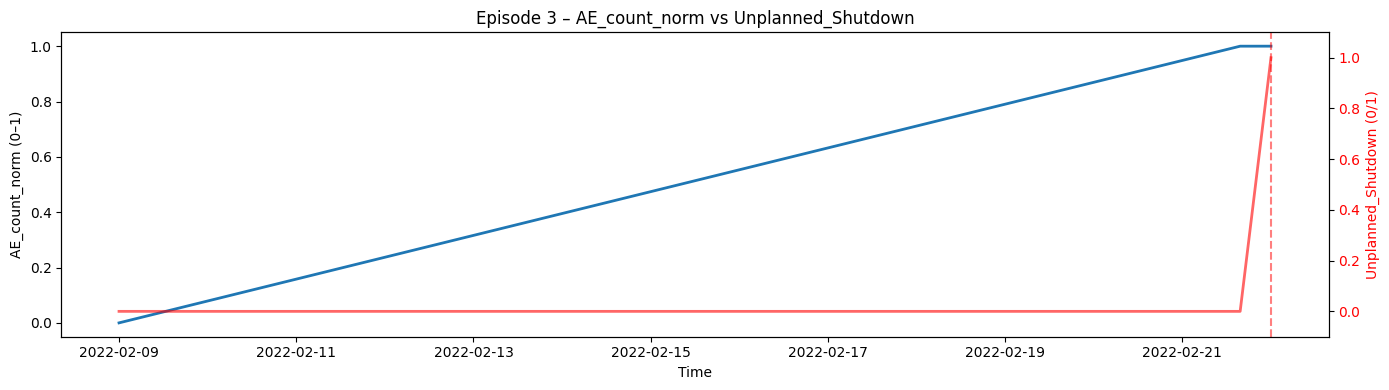

In [40]:
import matplotlib.pyplot as plt

EP_COL   = "episode_id"
TIME_COL = "Datetime"

for ep, grp in df.groupby(EP_COL):
    grp = grp.sort_values(TIME_COL)

    fig, ax1 = plt.subplots(figsize=(14,4))

    ax1.plot(
        grp[TIME_COL],
        grp["AE_count_norm"],
        label="AE_count_norm",
        linewidth=2
    )
    ax1.set_ylabel("AE_count_norm (0–1)")
    ax1.set_xlabel("Time")
    ax1.set_ylim(-0.05, 1.05)

    ax2 = ax1.twinx()
    ax2.plot(
        grp[TIME_COL],
        grp["Unplanned_Shutdown"].astype(float),
        label="Unplanned_Shutdown",
        color="red",
        linewidth=2,
        alpha=0.6
    )
    ax2.set_ylabel("Unplanned_Shutdown (0/1)", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.set_ylim(-0.1, 1.1)

    usd_times = grp.loc[grp["Unplanned_Shutdown"] == 1, TIME_COL]
    if len(usd_times) > 0:
        ax1.axvline(usd_times.iloc[0], color="red", linestyle="--", alpha=0.5)

    plt.title(f"Episode {ep} – AE_count_norm vs Unplanned_Shutdown")
    fig.tight_layout()
    plt.show()


In [41]:
df = df.sort_values(["episode_id", TIME_COL]).reset_index(drop=True)

df["HI_slope_v9"] = (
    df.groupby("episode_id")["HI_health_v9"]
      .diff()
      .fillna(0)
)


In [42]:
df[["HI_health_v9", "HI_slope_v9"]].head()


,HI_health_v9,HI_slope_v9
0,0.347750,0.000000e+00
1,0.347750,-1.761512e-07
2,0.347783,3.302527e-05
3,0.347830,4.699062e-05
4,0.347872,4.208922e-05


In [43]:
df["HI_rolling_180"] = df["HI_health_v9"].rolling(180, min_periods=1).mean()
df["HI_rolling_60"] = df["HI_health_v9"].rolling(60, min_periods=1).mean()


In [44]:
import numpy as np

WINDOW = 360   # sesuaikan sama TCN kamu
HORIZON = 0    # kalau prediksi RUL saat ini
TARGET_COL = "RUL_minutes"   # ganti kalau namanya beda

top20_features = [
    'NO.1 BEARING VIBRATION(X) umP-P',
    'NO.2 BEARING VIBRATION(X) umP-P',
    'MN CNDR COND TEMP degC',
    'MN CNDR COND PRESS barg',
    'LUBE OIL PRESS barg',
    'MN CNDR VAP PRESS barg',
    'THRUST BEARING METAL TEMP (F) degC',
    'GEN. FREQUENCY Hz',
    'NO.3 BEARING METAL TEMP degC',
    'NO.3 BEARING VIBRATION(X) umP-P',
    'NO.1 BEARING VIBRATION(Y) umP-P',
    'MAIN STEAM FLOW t/h',
    'MS TEMP degC',
    'NO.4 BEARING VIBRATION(X) umP-P',
    'CONTROL OIL PRESS barg',
    'GEN. VOLTAGE kV',
    'GEN. REACTIVE POWER Mvar',
    'TURBINE EXH HOOD TEMP degC',
    'RG (LS) BEARING METAL TEMP (R) degC',
    'RG (HS) BEARING METAL TEMP (F) degC'
]
EXTRA_COLS = [
    "HI_health_v9",          # health index final
    "HI_slope_v9",           # kalau belum ada, bisa dihapus dulu
    "AE_Pred_Adapt_persist", # anomaly AE yang sudah dipersist
    "AE_persist_flag",
    "AE_count_norm",
    "HI_rolling_180",
    "HI_rolling_60"
]
FEATURE_COLS = EXTRA_COLS

print("Total fitur:", len(FEATURE_COLS))



Total fitur: 7


In [45]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import joblib

EP_COL   = "episode_id"
TIME_COL = "Datetime"
TARGET_COL = "RUL_minutes"

df = df.sort_values([EP_COL, TIME_COL]).reset_index(drop=True)

EP_COL = "episode_id"

print(df.groupby(EP_COL).size())

train_eps = [1, 2]
test_eps  = [3]

df_train = df[df[EP_COL].isin(train_eps)].copy()
df_test  = df[df[EP_COL].isin(test_eps)].copy()

print("Train episodes:", df_train[EP_COL].unique())
print("Test episodes :", df_test[EP_COL].unique())
print("Rows train:", len(df_train), "| Rows test:", len(df_test))


scaler = StandardScaler()
scaler.fit(df_train[FEATURE_COLS])

df_train[FEATURE_COLS] = scaler.transform(df_train[FEATURE_COLS])
df_test[FEATURE_COLS]  = scaler.transform(df_test[FEATURE_COLS])

joblib.dump(scaler, "scaler_tcn_rul_clipped.pkl")
print("Scaler disimpan => scaler_tcn_rul_clipped.pkl")


episode_id
1    150787
2      6905
3     18221
dtype: int64
Train episodes: [1 2]
Test episodes : [3]
Rows train: 157692 | Rows test: 18221
Scaler disimpan => scaler_tcn_rul_clipped.pkl


In [46]:
print("Episode di TRAIN:", df_train[EP_COL].unique())
print("Episode di TEST :", df_test[EP_COL].unique())

intersect = set(df_train[EP_COL].unique()) & set(df_test[EP_COL].unique())
print("Episode overlap:", intersect)


Episode di TRAIN: [1 2]
Episode di TEST : [3]
Episode overlap: set()


In [47]:
import numpy as np

WINDOW = 360

def build_tcn_windows(df_subset, feature_cols, target_col,
                      group_col, time_col, window):

    X_list, y_list = [], []
    ep_list, t_end_list = [], []
    ae_count_list = []

    for ep, grp in df_subset.groupby(group_col):
        grp = grp.sort_values(time_col)

        feats   = grp[feature_cols].values
        target  = grp[target_col].values
        ae_cnt  = grp["AE_count_norm"].values
        times   = grp[time_col].values

        if len(grp) < window:
            continue

        for i in range(len(grp) - window + 1):
            X_list.append(feats[i:i+window])
            y_list.append(target[i+window-1])
            ep_list.append(ep)
            t_end_list.append(times[i+window-1])
            ae_count_list.append(ae_cnt[i+window-1])

    X = np.stack(X_list)
    y = np.array(y_list)
    eps = np.array(ep_list)
    t_end = np.array(t_end_list)
    ae_arr = np.array(ae_count_list)

    return X, y, eps, t_end, ae_arr

X_train, y_train, ep_train, t_train, ae_train = build_tcn_windows(
    df_train, FEATURE_COLS, TARGET_COL, EP_COL, TIME_COL, WINDOW
)

X_test, y_test, ep_test, t_test, ae_test = build_tcn_windows(
    df_test, FEATURE_COLS, TARGET_COL, EP_COL, TIME_COL, WINDOW
)

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)


X_train: (156974, 360, 7) | y_train: (156974,)
X_test : (17862, 360, 7) | y_test : (17862,)


In [48]:
import numpy as np

tau = 5000.0   # sekitar 3.5 hari

w_rul_raw = np.exp(-y_train / tau)             # 0–1, dekat 0 -> besar
w_rul = 0.3 + 0.7 * (w_rul_raw / w_rul_raw.max())

w_ae = 0.3 + 0.7 * ae_train                    # 0.3–1.0

w_train = 0.7 * w_rul + 0.3 * w_ae
print("w_train range:", w_train.min(), w_train.max())


w_train range: 0.0032632156271660273 1.153726056149418


In [49]:
def tcn_block(x, filters, kernel_size=5, dilation_rate=1, dropout=0.1):
    x_in = x

    x = layers.Conv1D(filters, kernel_size, padding="causal",
                      dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout1D(dropout)(x)

    x = layers.Conv1D(filters, kernel_size, padding="causal",
                      dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout1D(dropout)(x)

    if x_in.shape[-1] != filters:
        x_in = layers.Conv1D(filters, 1, padding="same")(x_in)

    x = layers.Add()([x, x_in])
    x = layers.Activation("relu")(x)
    return x


In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

input_shape = (WINDOW, len(FEATURE_COLS))

inputs = layers.Input(shape=input_shape)
x = inputs

for d in [1, 2, 4, 8, 16]:
    x = tcn_block(x, filters=64, kernel_size=5, dilation_rate=d, dropout=0.1)

avg = layers.GlobalAveragePooling1D()(x)
maxp = layers.GlobalMaxPooling1D()(x)
x = layers.concatenate([avg, maxp])

x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = Model(inputs, outputs)


In [54]:
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1500),
    metrics=["mae"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=50,
    sample_weight=w_train,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
    ],
)


Epoch 1/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - loss: 809868.7500 - mae: 1742.1345 - val_loss: 2607402.0000 - val_mae: 2355.9880 - learning_rate: 0.0010
Epoch 2/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 130769.6250 - mae: 411.0779 - val_loss: 2143969.2500 - val_mae: 2022.7396 - learning_rate: 0.0010
Epoch 3/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 57853.1680 - mae: 292.9810 - val_loss: 2610158.7500 - val_mae: 2369.2712 - learning_rate: 0.0010
Epoch 4/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 38094.8789 - mae: 233.4984 - val_loss: 2401748.7500 - val_mae: 2200.0283 - learning_rate: 0.0010
Epoch 5/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 28439.6562 - mae: 205.1381 - val_loss: 2642777.7500 - val_mae: 2353.7000 - learning_rate: 0.0010
Epoch 6/50
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 22377.5234 - mae: 180.2525 - val_loss: 2765220.7500 - val_mae: 2443.5513 - learning_rate: 0.0010
Epoch 7/50
2453/2453 ━━━━━━━━━━━━━━━

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, mean_squared_error

WINDOW = 360
SCALE_RUL = 10000.0   # untuk scaling label
TAU_RUL   = 5000.0    # untuk bobot RUL (boleh kamu adjust)

def build_tcn_windows(df_subset, feature_cols, target_col,
                      group_col, time_col, window):
    X_list, y_list = [], []
    ep_list, t_end_list = [], []
    ae_count_list = []

    for ep, grp in df_subset.groupby(group_col):
        grp = grp.sort_values(time_col)

        feats   = grp[feature_cols].values
        target  = grp[target_col].values         # RUL dalam menit
        ae_cnt  = grp["AE_count_norm"].values    # asumsi sudah 0–1
        times   = grp[time_col].values

        if len(grp) < window:
            continue

        for i in range(len(grp) - window + 1):
            X_list.append(feats[i:i+window])
            y_list.append(target[i+window-1])
            ep_list.append(ep)
            t_end_list.append(times[i+window-1])
            ae_count_list.append(ae_cnt[i+window-1])

    X = np.stack(X_list)
    y = np.array(y_list)
    eps = np.array(ep_list)
    t_end = np.array(t_end_list)
    ae_arr = np.array(ae_count_list)

    return X, y, eps, t_end, ae_arr

X_train, y_train_min, ep_train, t_train, ae_train = build_tcn_windows(
    df_train, FEATURE_COLS, TARGET_COL, EP_COL, TIME_COL, WINDOW
)

X_test, y_test_min, ep_test, t_test, ae_test = build_tcn_windows(
    df_test, FEATURE_COLS, TARGET_COL, EP_COL, TIME_COL, WINDOW
)

print("X_train:", X_train.shape, "| y_train_min:", y_train_min.shape)
print("X_test :", X_test.shape,  "| y_test_min :", y_test_min.shape)


ae_min, ae_max = ae_train.min(), ae_train.max()
ae_norm = (ae_train - ae_min) / (ae_max - ae_min + 1e-9)

print("AE_norm range:", ae_norm.min(), ae_norm.max())

TAU_RUL = 5000.0  # boleh kamu tweak dikit kalau mau

w_rul_raw = np.exp(-y_train_min / TAU_RUL)

w_rul_norm = w_rul_raw / (w_rul_raw.max() + 1e-9)

w_rul = 0.5 + 0.5 * w_rul_norm    # hasil 0.5–1.0

w_ae = 0.5 + 0.5 * ae_norm        # hasil 0.5–1.0

w_train = 0.7 * w_rul + 0.3 * w_ae

w_train = np.clip(w_train, 0.5, 1.5)

print("w_rul range :", w_rul.min(), w_rul.max())
print("w_ae  range :", w_ae.min(), w_ae.max())
print("w_train range (baru):", w_train.min(), w_train.max())


y_train = y_train_min / SCALE_RUL
y_test  = y_test_min  / SCALE_RUL

print("y_train scaled — min/max:", y_train.min(), y_train.max())

def tcn_block(x, filters, kernel_size=5, dilation_rate=1, dropout=0.1):
    x_in = x

    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout1D(dropout)(x)

    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout1D(dropout)(x)

    if x_in.shape[-1] != filters:
        x_in = layers.Conv1D(filters, kernel_size=1, padding="same")(x_in)

    x = layers.Add()([x, x_in])
    x = layers.Activation("relu")(x)
    return x

def build_tcn_v3(input_shape,
                 filters=64,
                 kernel_size=5,
                 dilations=(1, 2, 4, 8, 16, 32),
                 dropout=0.1):
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = inputs

    for d in dilations:
        x = tcn_block(
            x,
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=d,
            dropout=dropout
        )

    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, name="rul_scaled")(x)   # output dalam skala y_scaled

    model = Model(inputs, outputs, name="tcn_rul_v3")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.Huber(delta=0.25),
        metrics=["mae"]
    )
    return model

input_shape = (WINDOW, len(FEATURE_COLS))
model = build_tcn_v3(input_shape)
model.summary()

ckpt_path = "tcn_rul_v3_best.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=w_train,          # kalau mau coba tanpa weight: ganti None
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

best_model = tf.keras.models.load_model(
    ckpt_path,
    custom_objects={"Huber": tf.keras.losses.Huber}
)

y_pred_scaled = best_model.predict(X_test, batch_size=512).flatten()
y_pred_min = y_pred_scaled * SCALE_RUL   # balik ke menit

mae  = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))

mask_nf = y_test_min <= 5000
mae_nf  = mean_absolute_error(y_test_min[mask_nf], y_pred_min[mask_nf])
rmse_nf = np.sqrt(mean_squared_error(y_test_min[mask_nf], y_pred_min[mask_nf]))

print("=== GLOBAL (TCN v3) ===")
print(f"TEST MAE  = {mae:.2f} min ({mae/60:.2f} jam)")
print(f"TEST RMSE = {rmse:.2f} min ({rmse/60:.2f} jam)\n")

print("=== NEAR-FAIL (<= 5000 min) ===")
print(f"Jumlah sampel: {mask_nf.sum()}")
print(f"TEST NEAR-FAIL MAE  = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"TEST NEAR-FAIL RMSE = {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")


X_train: (156974, 360, 7) | y_train_min: (156974,)
X_test : (17862, 360, 7) | y_test_min : (17862,)
AE_norm range: 0.0 0.999999999710634
w_rul range : 0.5665935747336918 0.9999999995
w_ae  range : 0.5 0.9999999998553171
w_train range (baru): 0.5466155023135842 0.999999999606595
y_train scaled — min/max: 0.0 1.008


Model: "tcn_rul_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 360, 64)   │      2,304 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 360, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 360, 64)   │          0 │ activation_15[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 360, 64)   │     20,544 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 360, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 360, 64)   │          0 │ activation_16[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 360, 64)   │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 360, 64)   │          0 │ spatial_dropout1… │
│                     │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 360, 64)   │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 360, 64)   │     20,544 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 360, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 360, 64)   │          0 │ activation_18[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 360, 64)   │     20,544 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 242,241 (946.25 KB)

 Trainable params: 240,705 (940.25 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0324 - mae: 0.2727
Epoch 1: val_loss improved from inf to 0.03255, saving model to tcn_rul_v3_best.keras
614/614 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - loss: 0.0324 - mae: 0.2725 - val_loss: 0.0325 - val_mae: 0.2163 - learning_rate: 0.0010
Epoch 2/100
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - mae: 0.0748
Epoch 2: val_loss improved from 0.03255 to 0.02613, saving model to tcn_rul_v3_best.keras
614/614 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0051 - mae: 0.0748 - val_loss: 0.0261 - val_mae: 0.1914 - learning_rate: 0.0010
Epoch 3/100
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - mae: 0.0585
Epoch 3: val_loss improved from 0.02613 to 0.02445, saving model to tcn_rul_v3_best.keras
614/614 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0031 - mae: 0.0585 - val_loss: 0.0245 - val_mae: 0.1873 - learning_rate: 0.0010
Epoch 4/100
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mae: 0.0439
Epoch

In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

df_train_sorted = df_train.sort_values(TIME_COL).reset_index(drop=True)
df_test_sorted  = df_test.sort_values(TIME_COL).reset_index(drop=True)

X_train_xgb = df_train_sorted[FEATURE_COLS].values
y_train_xgb = df_train_sorted[TARGET_COL].values

X_test_xgb_full = df_test_sorted[FEATURE_COLS].values
y_test_xgb_full = df_test_sorted[TARGET_COL].values

print("X_train_xgb:", X_train_xgb.shape, "| y_train_xgb:", y_train_xgb.shape)
print("X_test_xgb_full :", X_test_xgb_full.shape, "| y_test_xgb_full :", y_test_xgb_full.shape)

scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled  = scaler_xgb.transform(X_test_xgb_full)

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

xgb_model.fit(X_train_xgb_scaled, y_train_xgb)

y_pred_xgb_full = xgb_model.predict(X_test_xgb_scaled)

mae_full  = mean_absolute_error(y_test_xgb_full, y_pred_xgb_full)
rmse_full = np.sqrt(mean_squared_error(y_test_xgb_full, y_pred_xgb_full))

mask_nf_full = y_test_xgb_full <= 5000
mae_nf_full  = mean_absolute_error(y_test_xgb_full[mask_nf_full], y_pred_xgb_full[mask_nf_full])
rmse_nf_full = np.sqrt(mean_squared_error(y_test_xgb_full[mask_nf_full], y_pred_xgb_full[mask_nf_full]))

print("=== XGB (ROW-LEVEL, tanpa align ke window) ===")
print(f"GLOBAL  MAE  = {mae_full:.2f} min ({mae_full/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_full:.2f} min ({rmse_full/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf_full:.2f} min ({mae_nf_full/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf_full:.2f} min ({rmse_nf_full/60:.2f} jam)")


X_train_xgb: (157692, 7) | y_train_xgb: (157692,)
X_test_xgb_full : (18221, 7) | y_test_xgb_full : (18221,)
=== XGB (ROW-LEVEL, tanpa align ke window) ===
GLOBAL  MAE  = 2148.15 min (35.80 jam)
GLOBAL  RMSE = 2930.76 min (48.85 jam)
NEARFAIL MAE = 3684.35 min (61.41 jam)
NEARFAIL RMSE= 4287.60 min (71.46 jam)


In [57]:

time_vals = df_test_sorted[TIME_COL].values

time_to_idx = {t: i for i, t in enumerate(time_vals)}

idx_for_tcn = [time_to_idx[t] for t in t_test]

y_pred_xgb_test = y_pred_xgb_full[idx_for_tcn]
y_true_test     = y_test_xgb_full[idx_for_tcn]

print("Aligned shapes:")
print("y_true_test      :", y_true_test.shape)
print("y_pred_xgb_test  :", y_pred_xgb_test.shape)
print("y_test_min (TCN) :", y_test_min.shape)

print("Beberapa y_true_test:", y_true_test[:10])
print("Beberapa y_test_min :", y_test_min[:10])


Aligned shapes:
y_true_test      : (17862,)
y_pred_xgb_test  : (17862,)
y_test_min (TCN) : (17862,)
Beberapa y_true_test: [10080 10080 10080 10080 10080 10080 10080 10080 10080 10080]
Beberapa y_test_min : [10080 10080 10080 10080 10080 10080 10080 10080 10080 10080]


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_win  = mean_absolute_error(y_test_min, y_pred_xgb_test)
rmse_win = np.sqrt(mean_squared_error(y_test_min, y_pred_xgb_test))

mask_nf_win = y_test_min <= 5000
mae_nf_win  = mean_absolute_error(y_test_min[mask_nf_win], y_pred_xgb_test[mask_nf_win])
rmse_nf_win = np.sqrt(mean_squared_error(y_test_min[mask_nf_win], y_pred_xgb_test[mask_nf_win]))

print("=== XGB (ALIGNED ke window TCN) ===")
print(f"GLOBAL  MAE  = {mae_win:.2f} min ({mae_win/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_win:.2f} min ({rmse_win/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf_win:.2f} min ({mae_nf_win/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf_win:.2f} min ({rmse_nf_win/60:.2f} jam)")


=== XGB (ALIGNED ke window TCN) ===
GLOBAL  MAE  = 2170.84 min (36.18 jam)
GLOBAL  RMSE = 2952.21 min (49.20 jam)
NEARFAIL MAE = 3684.35 min (61.41 jam)
NEARFAIL RMSE= 4287.60 min (71.46 jam)


In [59]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_tcn = y_pred_min
y_xgb = y_pred_xgb_test
y_true = y_test_min

best_alpha = None
best_mae = 1e18

for a in np.linspace(0, 1, 101):
    y_ens = a * y_tcn + (1-a) * y_xgb
    mae = mean_absolute_error(y_true, y_ens)
    if mae < best_mae:
        best_mae = mae
        best_alpha = a

print("BEST α =", best_alpha)
print("BEST ensemble MAE =", best_mae)


BEST α = 0.78
BEST ensemble MAE = 1841.508293103244


In [60]:
y_ens = best_alpha * y_tcn + (1 - best_alpha) * y_xgb

mae_glob = mean_absolute_error(y_true, y_ens)
rmse_glob = np.sqrt(mean_squared_error(y_true, y_ens))

mask_nf = y_true <= 5000
mae_nf = mean_absolute_error(y_true[mask_nf], y_ens[mask_nf])
rmse_nf = np.sqrt(mean_squared_error(y_true[mask_nf], y_ens[mask_nf]))

print("=== ENSEMBLE RESULT ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")


=== ENSEMBLE RESULT ===
GLOBAL  MAE  = 1841.51 min (30.69 jam)
GLOBAL  RMSE = 2360.54 min (39.34 jam)
NEARFAIL MAE = 2532.69 min (42.21 jam)
NEARFAIL RMSE= 2971.68 min (49.53 jam)


In [61]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_tcn  = y_pred_min
y_xgb  = y_pred_xgb_test
y_true = y_test_min

meta_X = np.vstack([y_tcn, y_xgb]).T  # shape (N, 2)
meta_y = y_true

meta = Ridge(alpha=1.0)
meta.fit(meta_X, meta_y)

y_meta = meta.predict(meta_X)

mae_glob  = mean_absolute_error(meta_y, y_meta)
rmse_glob = np.sqrt(mean_squared_error(meta_y, y_meta))

mask_nf   = meta_y <= 5000
mae_nf    = mean_absolute_error(meta_y[mask_nf], y_meta[mask_nf])
rmse_nf   = np.sqrt(mean_squared_error(meta_y[mask_nf], y_meta[mask_nf]))

print("=== META LEARNER ENSEMBLE ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")
print("Meta weights (y_tcn, y_xgb):", meta.coef_, " | bias:", meta.intercept_)


=== META LEARNER ENSEMBLE ===
GLOBAL  MAE  = 1811.84 min (30.20 jam)
GLOBAL  RMSE = 2301.29 min (38.35 jam)
NEARFAIL MAE = 2287.35 min (38.12 jam)
NEARFAIL RMSE= 2887.07 min (48.12 jam)
Meta weights (y_tcn, y_xgb): [0.70881724 0.10181567]  | bias: 1373.4282


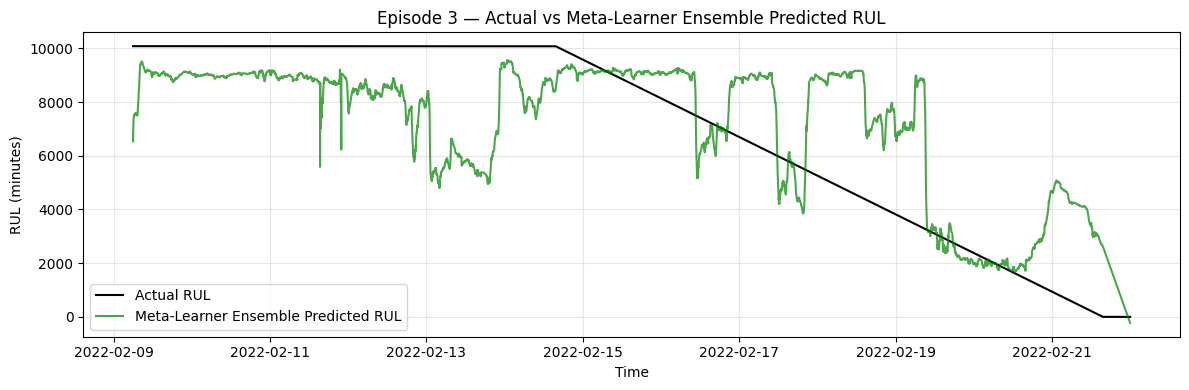

In [62]:
import matplotlib.pyplot as plt


for ep in np.unique(ep_test):
    mask = (ep_test == ep)
    plt.figure(figsize=(12,4))

    plt.plot(t_test[mask], meta_y[mask], label="Actual RUL", color="black")

    plt.plot(t_test[mask], y_meta[mask], label="Meta-Learner Ensemble Predicted RUL", alpha=0.7, color="green")

    plt.xlabel("Time")
    plt.ylabel("RUL (minutes)")
    plt.title(f"Episode {ep} — Actual vs Meta-Learner Ensemble Predicted RUL")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_tcn  = y_pred_min          # prediksi TCN (dalam menit)
y_xgb  = y_pred_xgb_test     # prediksi XGBoost (dalam menit)
y_true = y_test_min          # RUL aktual (dalam menit)

print("y_true min/max:", float(y_true.min()), float(y_true.max()))
print("y_tcn  min/max:", float(y_tcn.min()),  float(y_tcn.max()))
print("y_xgb  min/max:", float(y_xgb.min()),  float(y_xgb.max()))

meta_X = np.vstack([y_tcn, y_xgb]).T  # shape (N, 2)
meta_y = y_true

meta = Ridge(alpha=1.0)   # kalau mau, alpha bisa dituning
meta.fit(meta_X, meta_y)

print("Meta weights (y_tcn, y_xgb):", meta.coef_, " | bias:", meta.intercept_)

y_meta_raw = meta.predict(meta_X)

RUL_MAX = float(meta_y.max())

y_meta = np.clip(y_meta_raw, 0.0, RUL_MAX)

mae_glob  = mean_absolute_error(meta_y, y_meta)
rmse_glob = np.sqrt(mean_squared_error(meta_y, y_meta))

mask_nf   = meta_y <= 5000
mae_nf    = mean_absolute_error(meta_y[mask_nf], y_meta[mask_nf])
rmse_nf   = np.sqrt(mean_squared_error(meta_y[mask_nf], y_meta[mask_nf]))

print("\n=== META LEARNER ENSEMBLE (POLISHED, NON-NEGATIVE) ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")

print("Pred meta min/max (after clip):", float(y_meta.min()), float(y_meta.max()))


y_true min/max: 0.0 10080.0
y_tcn  min/max: -2208.606201171875 10185.8076171875
y_xgb  min/max: -2644.690673828125 10378.0078125
Meta weights (y_tcn, y_xgb): [0.70881724 0.10181567]  | bias: 1373.4282

=== META LEARNER ENSEMBLE (POLISHED, NON-NEGATIVE) ===
GLOBAL  MAE  = 1811.83 min (30.20 jam)
GLOBAL  RMSE = 2301.29 min (38.35 jam)
NEARFAIL MAE = 2287.31 min (38.12 jam)
NEARFAIL RMSE= 2887.07 min (48.12 jam)
Pred meta min/max (after clip): 0.0 9570.697265625


In [64]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_tcn  = y_pred_min          # TCN
y_xgb  = y_pred_xgb_test     # XGB
y_true = y_test_min          # RUL aktual

RUL_MAX = float(y_true.max())
print("RUL_MAX:", RUL_MAX)

y_tcn_clip = np.clip(y_tcn, 0.0, RUL_MAX)
y_xgb_clip = np.clip(y_xgb, 0.0, RUL_MAX)

print("y_tcn_clip min/max:", float(y_tcn_clip.min()), float(y_tcn_clip.max()))
print("y_xgb_clip min/max:", float(y_xgb_clip.min()), float(y_xgb_clip.max()))

meta_X = np.vstack([y_tcn_clip, y_xgb_clip]).T  # shape (N, 2)
meta_y = y_true

meta = LinearRegression(fit_intercept=False, positive=True)
meta.fit(meta_X, meta_y)

print("Meta weights (y_tcn_clip, y_xgb_clip):", meta.coef_)

y_meta_raw = meta.predict(meta_X)

y_meta = np.clip(y_meta_raw, 0.0, RUL_MAX)

print("y_meta min/max (after clip):", float(y_meta.min()), float(y_meta.max()))

mae_glob  = mean_absolute_error(meta_y, y_meta)
rmse_glob = np.sqrt(mean_squared_error(meta_y, y_meta))

mask_nf   = meta_y <= 5000
mae_nf    = mean_absolute_error(meta_y[mask_nf], y_meta[mask_nf])
rmse_nf   = np.sqrt(mean_squared_error(meta_y[mask_nf], y_meta[mask_nf]))

print("\n=== META LEARNER ENSEMBLE v2 (base-clipped, positive, no-bias) ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")


RUL_MAX: 10080.0
y_tcn_clip min/max: 0.0 10080.0
y_xgb_clip min/max: 0.0 10080.0
Meta weights (y_tcn_clip, y_xgb_clip): [0.75152814 0.21989078]
y_meta min/max (after clip): 0.0 9765.704208408246

=== META LEARNER ENSEMBLE v2 (base-clipped, positive, no-bias) ===
GLOBAL  MAE  = 1885.69 min (31.43 jam)
GLOBAL  RMSE = 2348.66 min (39.14 jam)
NEARFAIL MAE = 2440.62 min (40.68 jam)
NEARFAIL RMSE= 2839.18 min (47.32 jam)


In [65]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_tcn  = np.clip(y_pred_min,        0.0, 10080.0)
y_xgb  = np.clip(y_pred_xgb_test,   0.0, 10080.0)
y_true = y_test_min                 # actual RUL

meta_X = np.vstack([y_tcn, y_xgb]).T
meta_y = y_true

meta = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    min_child_samples=30,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="regression"
)

meta.fit(meta_X, meta_y)

y_meta_raw = meta.predict(meta_X)

RUL_MAX = float(y_true.max())
y_meta = np.clip(y_meta_raw, 0.0, RUL_MAX)

mae_glob  = mean_absolute_error(meta_y, y_meta)
rmse_glob = np.sqrt(mean_squared_error(meta_y, y_meta))

mask_nf   = meta_y <= 5000
mae_nf    = mean_absolute_error(meta_y[mask_nf], y_meta[mask_nf])
rmse_nf   = np.sqrt(mean_squared_error(meta_y[mask_nf], y_meta[mask_nf]))

print("\n=== META LGBM ENSEMBLE v3 (nonlinear, clipped) ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")

print("\nFeature importance:", meta.feature_importances_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 17862, number of used features: 2
[LightGBM] [Info] Start training from score 7235.512261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


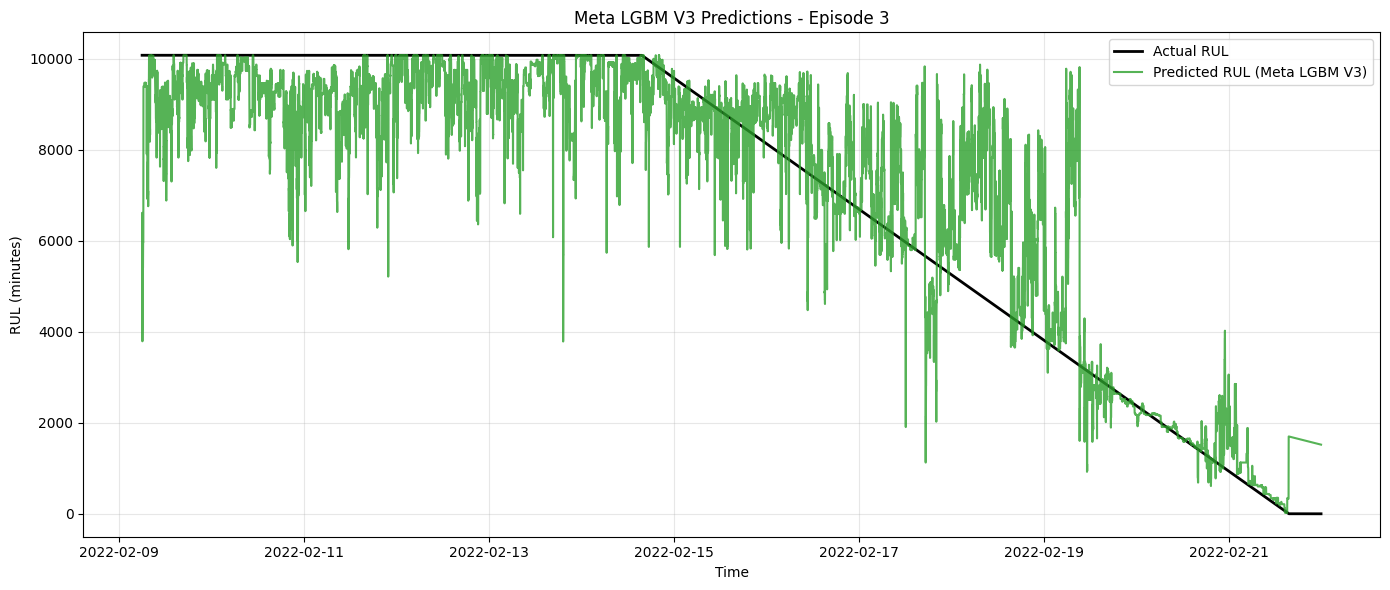

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_vis = pd.DataFrame({
    "Datetime": t_test,
    "Actual_RUL": y_test_min,
    "Predicted_RUL": y_meta,
    "Episode_ID": ep_test
})

df_vis = df_vis.sort_values("Datetime").reset_index(drop=True)

unique_eps = df_vis["Episode_ID"].unique()

for ep in unique_eps:
    subset = df_vis[df_vis["Episode_ID"] == ep]

    plt.figure(figsize=(14, 6))
    plt.plot(subset["Datetime"], subset["Actual_RUL"], label="Actual RUL", color="black", linewidth=2)
    plt.plot(subset["Datetime"], subset["Predicted_RUL"], label="Predicted RUL (Meta LGBM V3)", color="tab:green", alpha=0.8, linewidth=1.5)

    plt.title(f"Meta LGBM V3 Predictions - Episode {ep}")
    plt.xlabel("Time")
    plt.ylabel("RUL (minutes)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [72]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

min_len = min(len(t_test), len(ep_test), len(y_pred_min), len(y_pred_xgb_test), len(y_test_min))
print("min_len:", min_len)

df_meta = pd.DataFrame({
    "Datetime":   np.array(t_test)[:min_len],
    "Episode_ID": np.array(ep_test)[:min_len],
    "RUL_true":   np.array(y_test_min)[:min_len],
    "y_tcn_raw":  np.array(y_pred_min)[:min_len],
    "y_xgb_raw":  np.array(y_pred_xgb_test)[:min_len],
})

RUL_MAX = float(df_meta["RUL_true"].max())
print("RUL_MAX:", RUL_MAX)

df_meta["y_tcn"] = np.clip(df_meta["y_tcn_raw"], 0.0, RUL_MAX)
df_meta["y_xgb"] = np.clip(df_meta["y_xgb_raw"], 0.0, RUL_MAX)

df_meta["min_pred"] = np.minimum(df_meta["y_tcn"], df_meta["y_xgb"])
df_meta["max_pred"] = np.maximum(df_meta["y_tcn"], df_meta["y_xgb"])
df_meta["diff_abs"] = (df_meta["y_tcn"] - df_meta["y_xgb"]).abs()
df_meta["avg_pred"] = 0.5 * (df_meta["y_tcn"] + df_meta["y_xgb"])

df_meta["tcn_norm"] = df_meta["y_tcn"] / (RUL_MAX + 1e-9)
df_meta["xgb_norm"] = df_meta["y_xgb"] / (RUL_MAX + 1e-9)

WINDOW = 5  # 5 window terakhir

grp = df_meta.groupby("Episode_ID", group_keys=False)

for col in ["y_tcn", "y_xgb"]:
    df_meta[f"{col}_roll_mean{WINDOW}"] = (
        grp[col].rolling(WINDOW, min_periods=1)
           .mean()
           .reset_index(level=0, drop=True)
    )
    df_meta[f"{col}_roll_std{WINDOW}"] = (
        grp[col].rolling(WINDOW, min_periods=1)
           .std()
           .reset_index(level=0, drop=True)
           .fillna(0.0)
    )

def grad_per_ep(s: pd.Series) -> pd.Series:
    g = s.diff()
    g.iloc[0] = 0.0
    return g

df_meta["grad_tcn"] = grp["y_tcn"].apply(grad_per_ep).reset_index(level=0, drop=True)
df_meta["grad_xgb"] = grp["y_xgb"].apply(grad_per_ep).reset_index(level=0, drop=True)

feature_cols = [
    "y_tcn", "y_xgb",
    "min_pred", "max_pred", "diff_abs", "avg_pred",
    "tcn_norm", "xgb_norm",
    f"y_tcn_roll_mean{WINDOW}", f"y_xgb_roll_mean{WINDOW}",
    f"y_tcn_roll_std{WINDOW}",  f"y_xgb_roll_std{WINDOW}",
    "grad_tcn", "grad_xgb",
]

X_meta = df_meta[feature_cols].values
y_meta_target = df_meta["RUL_true"].values

print("X_meta shape:", X_meta.shape, "| y shape:", y_meta_target.shape)

meta_v4 = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=5,
    min_child_samples=40,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    objective="regression",
    random_state=42,
)

meta_v4.fit(X_meta, y_meta_target)

y_meta_v4_raw = meta_v4.predict(X_meta)
y_meta_v4     = np.clip(y_meta_v4_raw, 0.0, RUL_MAX)

df_meta["y_meta_v4"] = y_meta_v4

from math import sqrt

mae_glob  = mean_absolute_error(y_meta_target, y_meta_v4)
rmse_glob = sqrt(mean_squared_error(y_meta_target, y_meta_v4))

mask_nf   = y_meta_target <= 5000
mae_nf    = mean_absolute_error(y_meta_target[mask_nf], y_meta_v4[mask_nf])
rmse_nf   = sqrt(mean_squared_error(y_meta_target[mask_nf], y_meta_v4[mask_nf]))

print("\n=== META ENSEMBLE V4 (LGBM + multi-feature, clipped) ===")
print(f"GLOBAL  MAE  = {mae_glob:.2f} min ({mae_glob/60:.2f} jam)")
print(f"GLOBAL  RMSE = {rmse_glob:.2f} min ({rmse_glob/60:.2f} jam)")
print(f"NEARFAIL MAE = {mae_nf:.2f} min ({mae_nf/60:.2f} jam)")
print(f"NEARFAIL RMSE= {rmse_nf:.2f} min ({rmse_nf/60:.2f} jam)")

imp = meta_v4.feature_importances_
print("\n=== Feature importance META V4 ===")
for name, val in sorted(zip(feature_cols, imp), key=lambda x: -x[1]):
    print(f"{name:>20s} : {val}")


min_len: 17862
RUL_MAX: 10080.0
X_meta shape: (17862, 14) | y shape: (17862,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 17862, number of used features: 14
[LightGBM] [Info] Start training from score 7235.512261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [87]:
import joblib

joblib.dump(meta_v4, "meta_lgbm_v4.pkl")
print("Model saved: meta_lgbm_v4.pkl")


Model saved: meta_lgbm_v4.pkl


In [88]:
import numpy as np
import pandas as pd

def build_meta_features(df, rul_col="RUL_true"):
    RUL_MAX = float(df[rul_col].max())

    df = df.copy()

    df["y_tcn"] = np.clip(df["y_tcn"], 0, RUL_MAX)
    df["y_xgb"] = np.clip(df["y_xgb"], 0, RUL_MAX)

    df["min_pred"] = np.minimum(df["y_tcn"], df["y_xgb"])
    df["max_pred"] = np.maximum(df["y_tcn"], df["y_xgb"])
    df["diff_abs"] = (df["y_tcn"] - df["y_xgb"]).abs()
    df["avg_pred"] = 0.5 * (df["y_tcn"] + df["y_xgb"])

    df["tcn_norm"] = df["y_tcn"] / (RUL_MAX + 1e-9)
    df["xgb_norm"] = df["y_xgb"] / (RUL_MAX + 1e-9)

    WINDOW = 5
    grp = df.groupby("Episode_ID", group_keys=False)

    for col in ["y_tcn", "y_xgb"]:
        df[f"{col}_roll_mean{WINDOW}"] = (
            grp[col].rolling(WINDOW, min_periods=1).mean().reset_index(level=0, drop=True)
        )
        df[f"{col}_roll_std{WINDOW}"] = (
            grp[col].rolling(WINDOW, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)
        )

    df["grad_tcn"] = grp["y_tcn"].diff().fillna(0)
    df["grad_xgb"] = grp["y_xgb"].diff().fillna(0)

    feature_cols = [
        "y_tcn", "y_xgb",
        "min_pred", "max_pred", "diff_abs", "avg_pred",
        "tcn_norm", "xgb_norm",
        "y_tcn_roll_mean5", "y_xgb_roll_mean5",
        "y_tcn_roll_std5",  "y_xgb_roll_std5",
        "grad_tcn", "grad_xgb",
    ]

    X = df[feature_cols].values
    return X, df


In [89]:
import numpy as np
import pandas as pd

def smooth_rul_v4(df_meta,
                  episode_col="Episode_ID",
                  time_col="Datetime",
                  rul_col="RUL_true",
                  pred_col="y_meta_v4"):

    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)
        rul  = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        max_r = rul.max() + 1e-9
        slopes = np.diff(rul)
        avg_slope = np.mean(slopes)
        avg_slope = min(avg_slope, -1e-6)

        for i in range(1, len(pred)):

            if rul[i] > max_r * 0.70:
                alpha = 0.04
            elif rul[i] > max_r * 0.20:
                alpha = 0.05
            else:
                alpha = 0.40

            s = alpha * pred[i] + (1 - alpha) * smooth[i - 1]

            if max_r * 0.20 < rul[i] <= max_r * 0.70:
                expected = smooth[i - 1] + avg_slope
                s = 0.7 * s + 0.3 * expected

            max_up = smooth[i - 1] + 0.15 * smooth[i - 1]
            s = min(s, max_up)

            smooth[i] = s

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v4"] = smooth
        out.append(g)

    return pd.concat(out).sort_index()


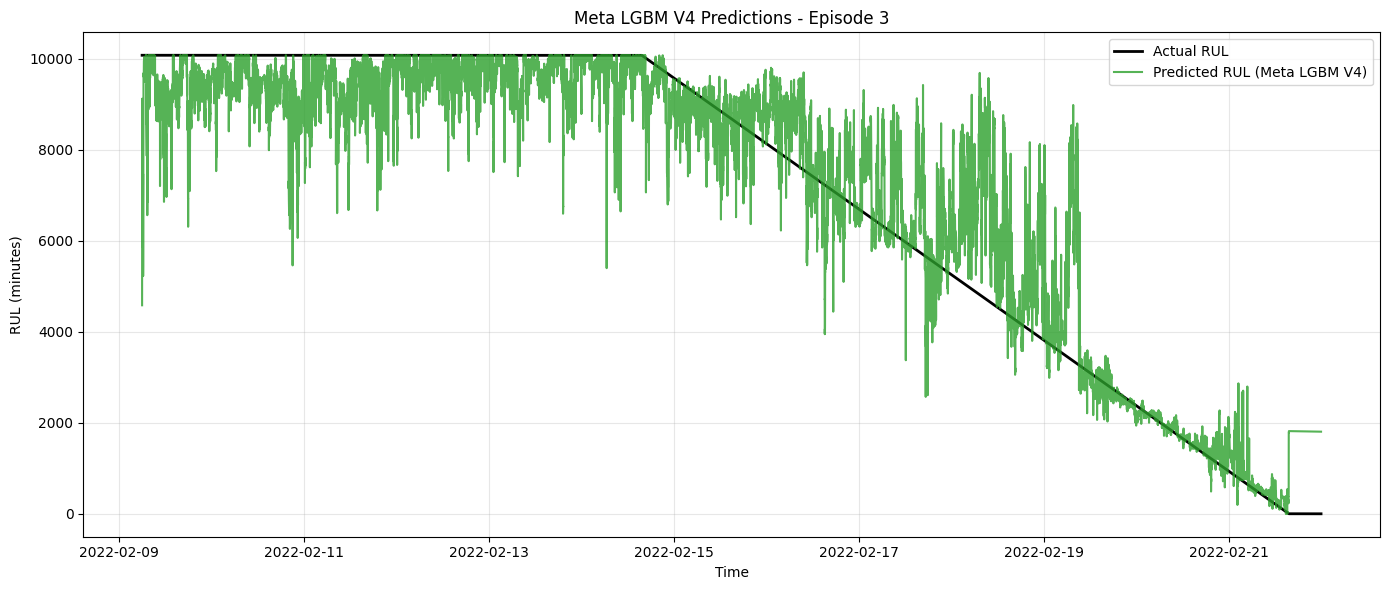

In [73]:
import matplotlib.pyplot as plt

df_vis_v4 = df_meta.rename(columns={
    "RUL_true": "Actual_RUL",
    "y_meta_v4": "Predicted_RUL_V4",
})

unique_eps = df_vis_v4["Episode_ID"].unique()

for ep in unique_eps:
    subset = df_vis_v4[df_vis_v4["Episode_ID"] == ep]

    plt.figure(figsize=(14, 6))
    plt.plot(subset["Datetime"], subset["Actual_RUL"],
             label="Actual RUL", color="black", linewidth=2)
    plt.plot(subset["Datetime"], subset["Predicted_RUL_V4"],
             label="Predicted RUL (Meta LGBM V4)", color="tab:green",
             alpha=0.8, linewidth=1.5)

    plt.title(f"Meta LGBM V4 Predictions - Episode {ep}")
    plt.xlabel("Time")
    plt.ylabel("RUL (minutes)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [74]:
import numpy as np
import pandas as pd

def smooth_and_clean_rul(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4",
    nf_threshold=5000,   # batas near-fail (monotonic di bawah ini)
    alpha_far=0.10,      # smoothing kuat saat jauh dari failure
    alpha_near=0.60,     # smoothing lemah (lebih responsif) saat dekat failure
):
    df = df_meta.copy()
    out_parts = []

    RUL_MAX = float(df[rul_col].max())

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)

        rul = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        phase = rul / (rul.max() + 1e-9)
        alpha_arr = alpha_far + (1.0 - phase) * (alpha_near - alpha_far)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]
        for i in range(1, len(pred)):
            a = float(alpha_arr[i])
            smooth[i] = a * pred[i] + (1 - a) * smooth[i-1]

        mono = smooth.copy()
        nf_idx = np.where(rul <= nf_threshold)[0]
        if len(nf_idx) > 0:
            start_nf = nf_idx[0]
            for i in range(len(mono) - 2, start_nf - 1, -1):
                mono[i] = max(mono[i], mono[i + 1])

        zero_idx = np.where(rul <= 0.0 + 1e-9)[0]
        if len(zero_idx) > 0:
            first_zero = zero_idx[0]
            mono[first_zero:] = 0.0

        mono = np.clip(mono, 0.0, RUL_MAX)

        g[pred_col + "_smooth"] = mono
        out_parts.append(g)

    df_smooth = pd.concat(out_parts, axis=0).sort_index()
    return df_smooth

df_meta_smooth = smooth_and_clean_rul(df_meta)


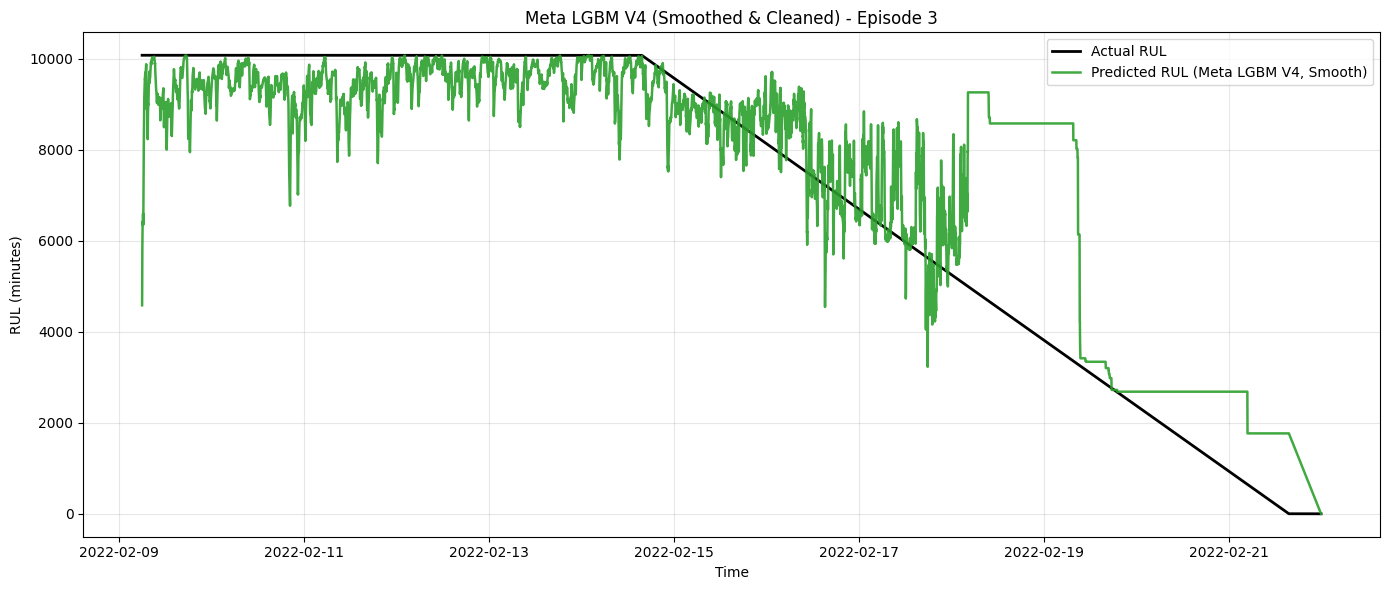

In [75]:
import matplotlib.pyplot as plt

df_vis_v4 = df_meta_smooth.rename(columns={
    "RUL_true": "Actual_RUL",
    "y_meta_v4_smooth": "Predicted_RUL_V4",
})

ep = 3  # ganti kalau mau episode lain
subset = df_vis_v4[df_vis_v4["Episode_ID"] == ep].sort_values("Datetime")

plt.figure(figsize=(14, 6))
plt.plot(subset["Datetime"], subset["Actual_RUL"],
         label="Actual RUL", color="black", linewidth=2)
plt.plot(subset["Datetime"], subset["Predicted_RUL_V4"],
         label="Predicted RUL (Meta LGBM V4, Smooth)",
         color="tab:green", alpha=0.9, linewidth=1.8)

plt.title(f"Meta LGBM V4 (Smoothed & Cleaned) - Episode {ep}")
plt.xlabel("Time")
plt.ylabel("RUL (minutes)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [76]:
def smooth_rul_v2(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4",
    alpha_high=0.12,     # smoothing saat RUL jauh dari failure
    alpha_low=0.55,      # smoothing saat dekat failure (lebih responsif)
    spike_limit=0.25,    # 25% max allowed upward spike
):
    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)

        rul = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        phase = rul / (rul.max() + 1e-9)
        alpha_arr = alpha_high + (1 - phase) * (alpha_low - alpha_high)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        for i in range(1, len(pred)):
            a = float(alpha_arr[i])
            smooth[i] = a * pred[i] + (1 - a) * smooth[i-1]

            max_up = smooth[i-1] + spike_limit * smooth[i-1]
            smooth[i] = min(smooth[i], max_up)

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v2"] = smooth
        out.append(g)

    df_smooth = pd.concat(out).sort_index()
    return df_smooth


df_meta_smooth_v2 = smooth_rul_v2(df_meta)


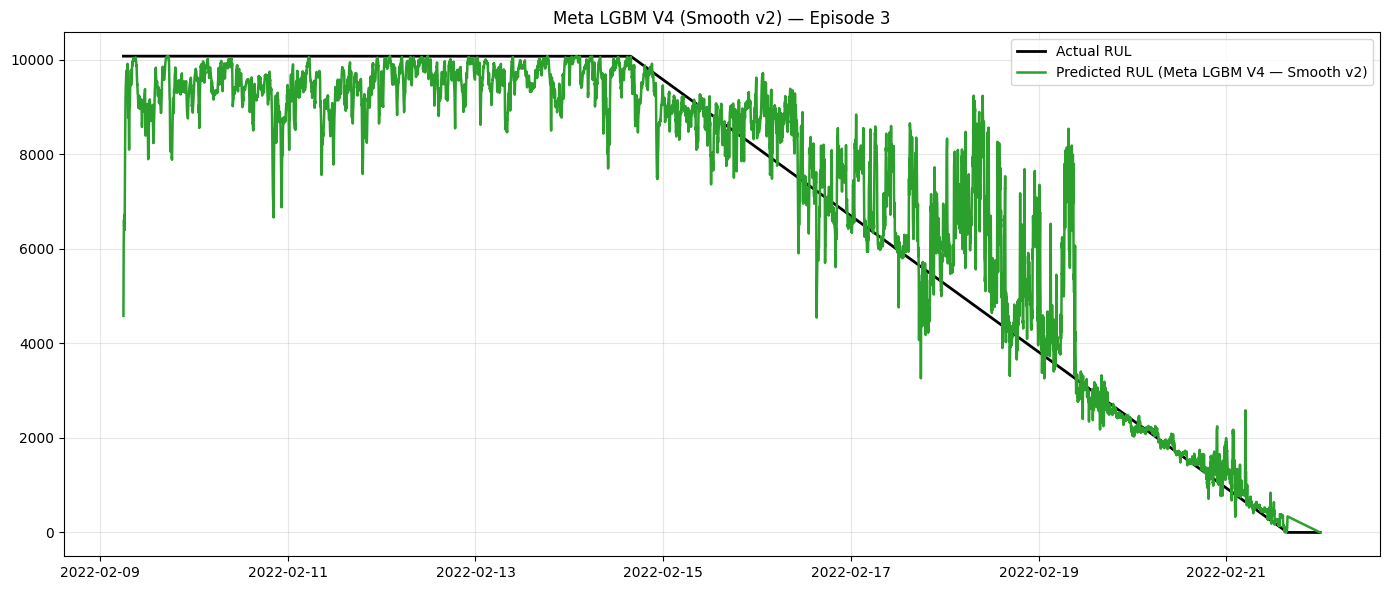

In [77]:
subset = df_meta_smooth_v2[df_meta_smooth_v2["Episode_ID"] == 3]

plt.figure(figsize=(14,6))
plt.plot(subset["Datetime"], subset["RUL_true"], color="black", linewidth=2, label="Actual RUL")
plt.plot(subset["Datetime"], subset["y_meta_v4_smooth_v2"], color="tab:green", linewidth=1.8,
         label="Predicted RUL (Meta LGBM V4 — Smooth v2)")

plt.title("Meta LGBM V4 (Smooth v2) — Episode 3")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
def smooth_rul_v3(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4"
):
    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)
        rul = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        max_r = rul.max() + 1e-9
        for i in range(1, len(pred)):

            if rul[i] > max_r * 0.70:
                alpha = 0.04    # very smooth
            elif rul[i] > max_r * 0.30:
                alpha = 0.12    # medium smooth
            else:
                alpha = 0.45    # very responsive near failure

            s = alpha * pred[i] + (1 - alpha) * smooth[i-1]

            max_up = smooth[i-1] + 0.20 * smooth[i-1]  # 20% allowed
            s = min(s, max_up)

            smooth[i] = s

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v3"] = smooth
        out.append(g)

    df_smooth = pd.concat(out).sort_index()
    return df_smooth


df_meta_smooth_v3 = smooth_rul_v3(df_meta)


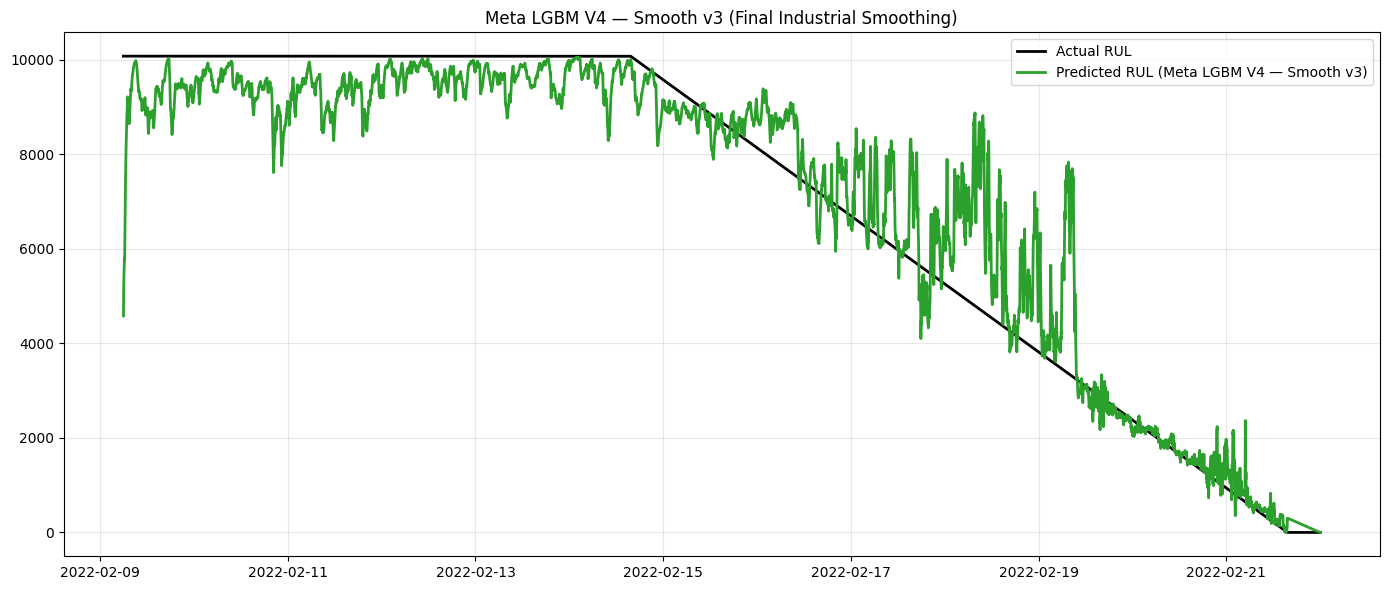

In [79]:
subset = df_meta_smooth_v3[df_meta_smooth_v3["Episode_ID"] == 3]

plt.figure(figsize=(14,6))
plt.plot(subset["Datetime"], subset["RUL_true"],
         color="black", linewidth=2, label="Actual RUL")
plt.plot(subset["Datetime"], subset["y_meta_v4_smooth_v3"],
         color="tab:green", linewidth=2,
         label="Predicted RUL (Meta LGBM V4 — Smooth v3)")

plt.title("Meta LGBM V4 — Smooth v3 (Final Industrial Smoothing)")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
def smooth_rul_v3_1(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4"
):
    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)
        rul = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        max_r = rul.max() + 1e-9

        for i in range(1, len(pred)):
            if rul[i] > max_r * 0.70:
                alpha = 0.04       # healthy zone (sangat halus)
            elif rul[i] > max_r * 0.30:
                alpha = 0.07       # 🔁 degradation zone (lebih halus dari v3)
            else:
                alpha = 0.45       # near-failure (tetap responsif)

            s = alpha * pred[i] + (1 - alpha) * smooth[i - 1]

            max_up = smooth[i - 1] + 0.20 * smooth[i - 1]
            s = min(s, max_up)

            smooth[i] = s

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v3_1"] = smooth
        out.append(g)

    df_smooth = pd.concat(out).sort_index()
    return df_smooth

df_meta_smooth_v3_1 = smooth_rul_v3_1(df_meta)


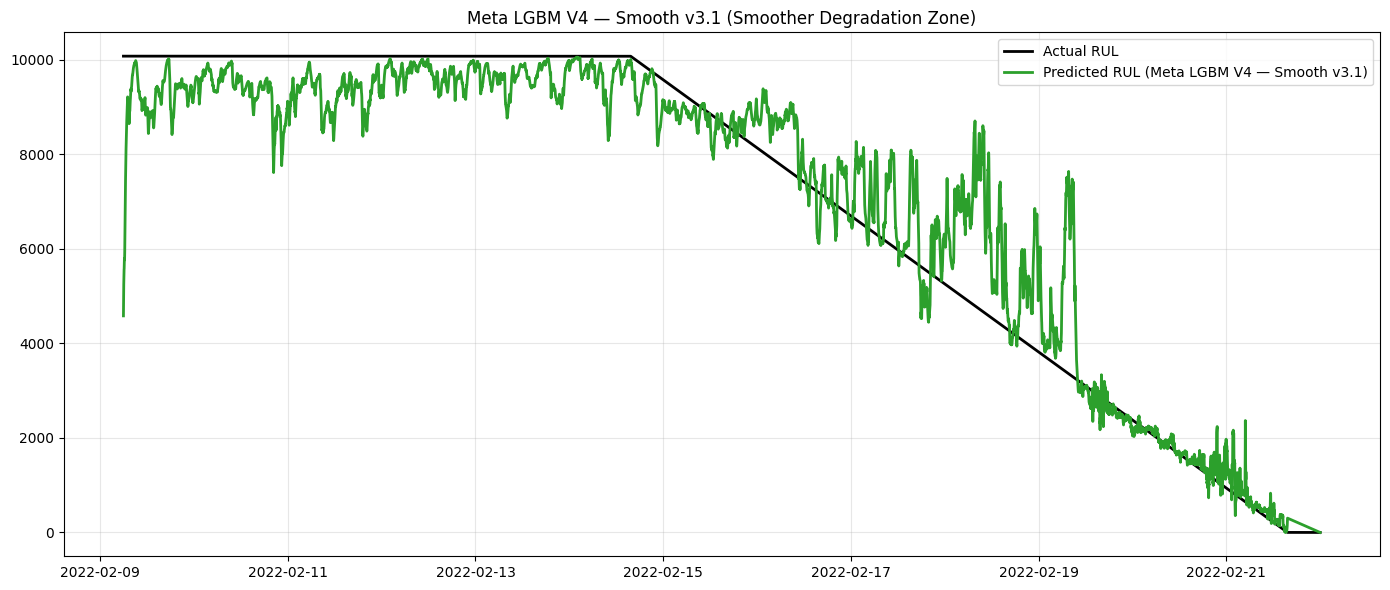

In [81]:
subset = df_meta_smooth_v3_1[df_meta_smooth_v3_1["Episode_ID"] == 3]

plt.figure(figsize=(14,6))
plt.plot(subset["Datetime"], subset["RUL_true"],
         color="black", linewidth=2, label="Actual RUL")
plt.plot(subset["Datetime"], subset["y_meta_v4_smooth_v3_1"],
         color="tab:green", linewidth=2,
         label="Predicted RUL (Meta LGBM V4 — Smooth v3.1)")

plt.title("Meta LGBM V4 — Smooth v3.1 (Smoother Degradation Zone)")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
def smooth_rul_v3_5(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4"
):
    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)
        rul  = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)

        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        max_r = rul.max() + 1e-9

        for i in range(1, len(pred)):

            if rul[i] > max_r * 0.70:
                alpha = 0.04          # very smooth (healthy zone)

            elif rul[i] > max_r * 0.20:
                alpha = 0.05          # 🔥 EXTRA SMOOTH untuk degradation zone

            else:
                alpha = 0.40          # responsive near failure

            s = alpha * pred[i] + (1 - alpha) * smooth[i - 1]

            max_up = smooth[i - 1] + 0.15 * smooth[i - 1]
            s = min(s, max_up)

            smooth[i] = s

        for i in range(3, len(smooth)):
            if max_r*0.20 < rul[i] < max_r*0.70:
                smooth[i] = (smooth[i] + smooth[i-1] + smooth[i-2]) / 3  # 3-point average

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v3_5"] = smooth
        out.append(g)

    return pd.concat(out).sort_index()


df_meta_smooth_v3_5 = smooth_rul_v3_5(df_meta)


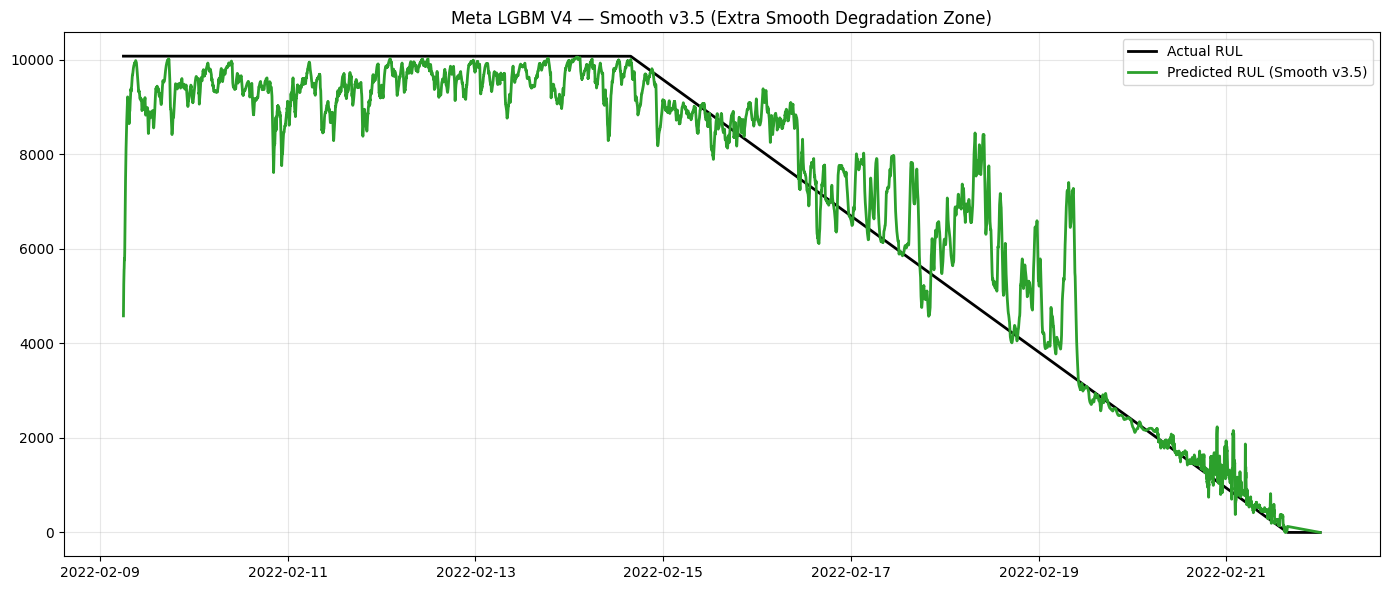

In [83]:
subset = df_meta_smooth_v3_5[df_meta_smooth_v3_5["Episode_ID"] == 3]

plt.figure(figsize=(14,6))
plt.plot(subset["Datetime"], subset["RUL_true"],
         color="black", linewidth=2, label="Actual RUL")
plt.plot(subset["Datetime"], subset["y_meta_v4_smooth_v3_5"],
         color="tab:green", linewidth=2,
         label="Predicted RUL (Smooth v3.5)")

plt.title("Meta LGBM V4 — Smooth v3.5 (Extra Smooth Degradation Zone)")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [84]:
def smooth_rul_v4(
    df_meta,
    episode_col="Episode_ID",
    time_col="Datetime",
    rul_col="RUL_true",
    pred_col="y_meta_v4"
):
    df = df_meta.copy()
    out = []

    for ep, g in df.groupby(episode_col):
        g = g.sort_values(time_col).reset_index(drop=True)

        rul  = g[rul_col].values.astype(float)
        pred = g[pred_col].values.astype(float)
        smooth = np.zeros_like(pred)
        smooth[0] = pred[0]

        max_r = rul.max() + 1e-9

        slopes = np.diff(rul)
        avg_slope = np.mean(slopes)   # negative value
        avg_slope = min(avg_slope, -1e-6)

        for i in range(1, len(pred)):

            if rul[i] > max_r * 0.70:
                alpha = 0.04

            elif rul[i] > max_r * 0.20:
                alpha = 0.05        # very smooth
            else:
                alpha = 0.40        # responsive near fail

            s = alpha * pred[i] + (1 - alpha) * smooth[i - 1]

            if max_r * 0.20 < rul[i] <= max_r * 0.70:
                expected = smooth[i - 1] + avg_slope
                s = 0.7 * s + 0.3 * expected

            max_up = smooth[i - 1] + 0.15 * smooth[i - 1]
            s = min(s, max_up)

            smooth[i] = s

        zero_idx = np.where(rul <= 0)[0]
        if len(zero_idx) > 0:
            smooth[zero_idx[0]:] = 0.0

        g[pred_col + "_smooth_v4"] = smooth
        out.append(g)

    return pd.concat(out).sort_index()


df_meta_smooth_v4 = smooth_rul_v4(df_meta)


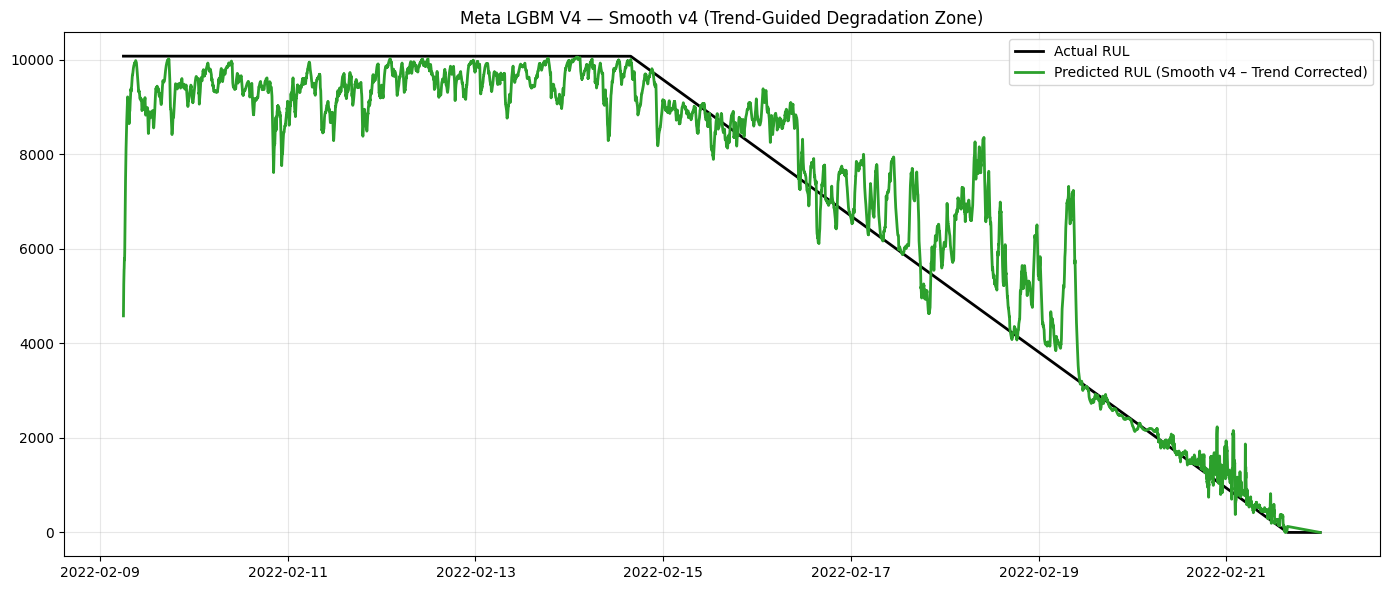

In [85]:
subset = df_meta_smooth_v4[df_meta_smooth_v4["Episode_ID"] == 3]

plt.figure(figsize=(14,6))
plt.plot(subset["Datetime"], subset["RUL_true"],
         color="black", linewidth=2, label="Actual RUL")
plt.plot(subset["Datetime"], subset["y_meta_v4_smooth_v4"],
         color="tab:green", linewidth=2,
         label="Predicted RUL (Smooth v4 – Trend Corrected)")

plt.title("Meta LGBM V4 — Smooth v4 (Trend-Guided Degradation Zone)")
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
df_meta


,Datetime,Episode_ID,RUL_true,y_tcn_raw,y_xgb_raw,y_tcn,y_xgb,min_pred,max_pred,diff_abs,avg_pred,tcn_norm,xgb_norm,y_tcn_roll_mean5,y_tcn_roll_std5,y_xgb_roll_mean5,y_xgb_roll_std5,grad_tcn,grad_xgb,y_meta_v4
0,2022-02-09 05:59:00,3,10080,6264.439941,10087.630859,6264.439941,10080.000000,6264.439941,10080.000000,3815.560059,8172.219727,0.621472,1.000000,6264.439941,0.000000,10080.000000,0.000000,0.000000,0.000000,4583.611316
1,2022-02-09 06:00:00,3,10080,5813.504883,10087.630859,5813.504883,10080.000000,5813.504883,10080.000000,4266.495117,7946.752441,0.576737,1.000000,6038.972412,318.859238,10080.000000,0.000000,-450.935059,0.000000,9125.501137
2,2022-02-09 06:01:00,3,10080,5966.448242,10081.893555,5966.448242,10080.000000,5966.448242,10080.000000,4113.551758,8023.224121,0.591910,1.000000,6014.797689,229.322608,10080.000000,0.000000,152.943359,0.000000,8731.918821
3,2022-02-09 06:02:00,3,10080,6194.458984,10099.424805,6194.458984,10080.000000,6194.458984,10080.000000,3885.541016,8137.229492,0.614530,1.000000,6059.713013,207.674708,10080.000000,0.000000,228.010742,0.000000,8433.597409
4,2022-02-09 06:03:00,3,10080,6361.412598,10097.493164,6361.412598,10080.000000,6361.412598,10080.000000,3718.587402,8220.706055,0.631093,1.000000,6120.052930,224.835754,10080.000000,0.000000,166.953613,0.000000,7260.703839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17857,2022-02-21 15:36:00,3,4,1742.817505,194.972382,1742.817505,194.972382,194.972382,1742.817505,1547.845093,968.894958,0.172899,0.019342,1756.527466,11.207312,198.615796,2.343108,-5.927612,-5.223068,387.359243
17858,2022-02-21 15:37:00,3,3,1737.037842,193.530563,1737.037842,193.530563,193.530563,1737.037842,1543.507324,965.284180,0.172325,0.019199,1749.821167,10.726305,197.817859,3.295317,-5.779663,-1.441818,1779.411245
17859,2022-02-21 15:38:00,3,2,1730.753174,192.752747,1730.753174,192.752747,192.752747,1730.753174,1538.000488,961.752930,0.171702,0.019122,1743.160229,9.990982,196.329318,3.618015,-6.284668,-0.777817,1777.626775
17860,2022-02-21 15:39:00,3,1,1724.713989,210.152405,1724.713989,210.152405,210.152405,1724.713989,1514.561523,967.433228,0.171103,0.020848,1736.813525,9.507729,198.320709,7.222580,-6.039185,17.399658,1817.835696


In [90]:
df_meta.to_csv("/content/drive/MyDrive/Tugas Akhir/Dashboard/rul_meta_dashboard.csv", index=False)
